In [1]:
import glob
import os
import re
import numpy as np
import pandas as pd
import geopandas as gpd
import rasterio
from rasterio.mask import geometry_mask
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

import statsmodels.api as sm
from statsmodels.formula.api import ols
import statsmodels.stats.multicomp as multi

In [2]:
# Define the directories containing images and shapefiles
image_dir = "C:\\Users\\Student\\Documents\\101_walrus_data\\train\\clipped_images"
shapefile_dir = "C:\\Users\\Student\\Documents\\101_walrus_data\\train\\clipped_train"
unlabeled_image_dir = "C:\\Users\\Student\\Documents\\101_walrus_data\\train\\clipped_unlabeled"

# Use glob to list all .tif and .shp files in the specified directories
image_paths = glob.glob(f"{image_dir}/*.tif")
shapefile_paths = glob.glob(f"{shapefile_dir}/*.shp")
unlabeled_image_paths = glob.glob(f"{unlabeled_image_dir}/*.tif")

# Function to extract island name and date from file names
def extract_island_and_date(filename):
    pattern = r'([a-zA-Z]+)_(\d{8})'
    match = re.search(pattern, filename)
    if match:
        return match.group(1), match.group(2)
    return None, None

# Create a dictionary to store paired image and shapefile paths
file_pairs = {}

# Pair image and shapefile paths based on filenames
for image_path in image_paths:
    island, date = extract_island_and_date(os.path.basename(image_path))
    if island is None or date is None:
        print(f"Failed to extract island and date from {image_path}")
        continue

    matching_shapefiles = [shapefile for shapefile in shapefile_paths if island in shapefile and date in shapefile]
    if not matching_shapefiles:
        print(f"No matching shapefile found for {image_path}")
        continue

    shapefile_path = matching_shapefiles[0]
    file_pairs[image_path] = shapefile_path

# Function to extract features and labels
def extract_features_labels(image_path, shapefile_path):
    with rasterio.open(image_path) as src:
        image = src.read()
        transform = src.transform

    gdf = gpd.read_file(shapefile_path)
    features = []
    labels = []
    img_name = []

    for _, row in gdf.iterrows():
        mask = geometry_mask([row['geometry']], transform=transform, invert=True, out_shape=(src.height, src.width))
        feature_pixels = image[:, mask]
        label = row['label']

        for pixel in feature_pixels.T:  # Transpose to iterate over pixels
            features.append(pixel)
            labels.append(label)
            img_name.append(image_path)

    return np.array(features), np.array(labels), np.array(img_name)

features = []
labels = []
image_name = []

for image_path, shapefile_path in file_pairs.items():
    img_features, img_labels, img_name = extract_features_labels(image_path, shapefile_path)
    features.append(img_features)
    labels.append(img_labels)
    image_name.append(img_name)

features = np.vstack(features)
labels = np.hstack(labels)
image_name = np.hstack(image_name)
print(features, labels, image_name)

# Encode labels
le = LabelEncoder()
encoded_labels = le.fit_transform(labels)

# Create DataFrame
dataset = pd.DataFrame({'Coast_blue': features[:, 0],
                        'Blue': features[:, 1],
                        'Green1': features[:, 2],
                        'Green': features[:, 3],
                        'Yellow': features[:, 4],
                        'Red': features[:, 5],
                        'Red_edge': features[:, 6],
                        'NIR': features[:, 7],
                        'labels': labels,
                        'encoded_labels': encoded_labels,
                        'image_name': image_name})


No matching shapefile found for C:\Users\Student\Documents\101_walrus_data\train\clipped_images\pool_20230803_image.tif
[[1187  980 1269 ... 1329 1416 1650]
 [1148  912 1212 ... 1240 1297 1612]
 [1131  856 1162 ... 1181 1355 1510]
 ...
 [1730 1870 1929 ... 2091 2276 2647]
 [1634 1851 1879 ... 2053 2281 2634]
 [1720 1904 1905 ... 2135 2316 2654]] ['walrus_mixed' 'walrus_mixed' 'walrus_mixed' ... 'freshwater'
 'freshwater' 'freshwater'] ['C:\\Users\\Student\\Documents\\101_walrus_data\\train\\clipped_images\\buch_20230714_image.tif'
 'C:\\Users\\Student\\Documents\\101_walrus_data\\train\\clipped_images\\buch_20230714_image.tif'
 'C:\\Users\\Student\\Documents\\101_walrus_data\\train\\clipped_images\\buch_20230714_image.tif'
 ...
 'C:\\Users\\Student\\Documents\\101_walrus_data\\train\\clipped_images\\tor_20230902_image.tif'
 'C:\\Users\\Student\\Documents\\101_walrus_data\\train\\clipped_images\\tor_20230902_image.tif'
 'C:\\Users\\Student\\Documents\\101_walrus_data\\train\\clipped_ima

In [3]:
# Define custom colors for the classes
custom_colors = {
    'ice': 'whitesmoke',
    'ocean': 'cornflowerblue',
    'rock': 'dimgrey',
    'freshwater': 'aquamarine',
    'walrus_pure': 'mediumorchid',
    'walrus_mixed': 'hotpink'
}

In [4]:
# Drop non-numeric columns before calculating mean and std
numeric_dataset = dataset.drop(columns=['labels', 'image_name'])

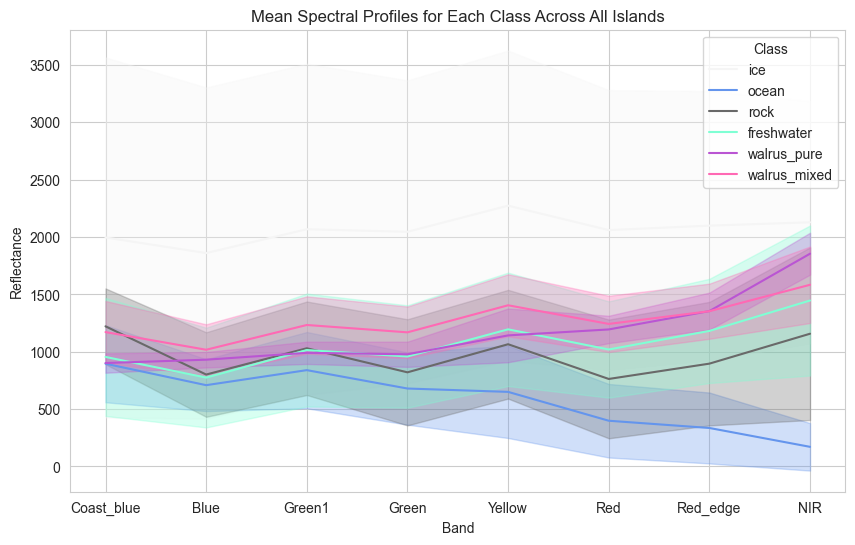

Islands found: ['buch' 'moff' 'pal' 'sars' 'tor']
Processing island: buch, number of samples: 553705
Label walrus_pure not found in island buch


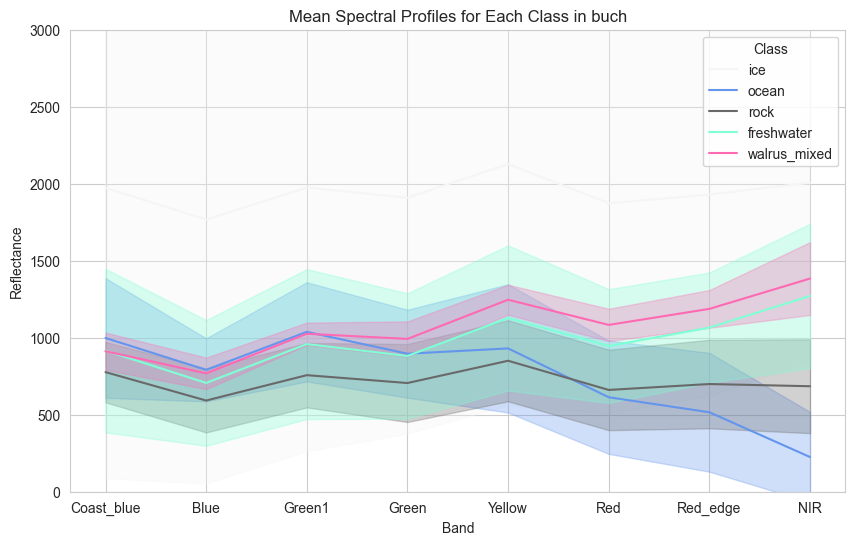

Processing island: moff, number of samples: 67507
Label rock not found in island moff
Label walrus_pure not found in island moff


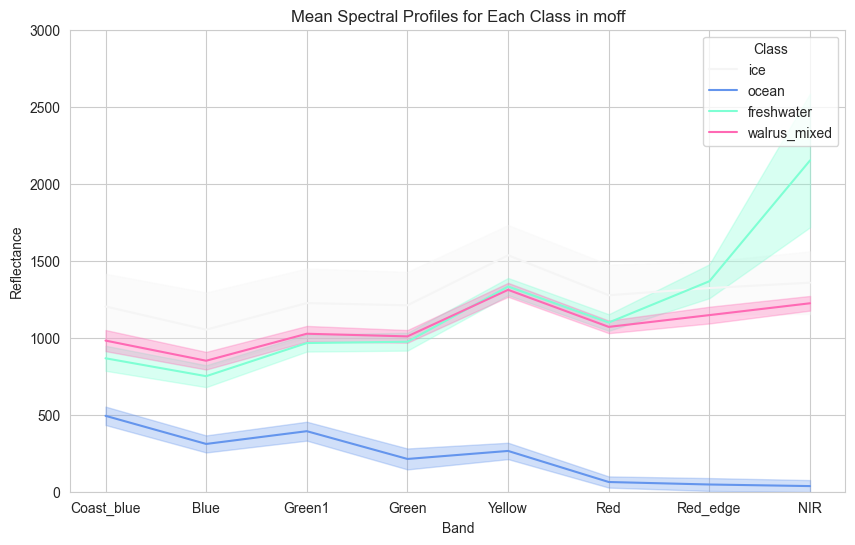

Processing island: pal, number of samples: 170474
Label freshwater not found in island pal
Label walrus_pure not found in island pal


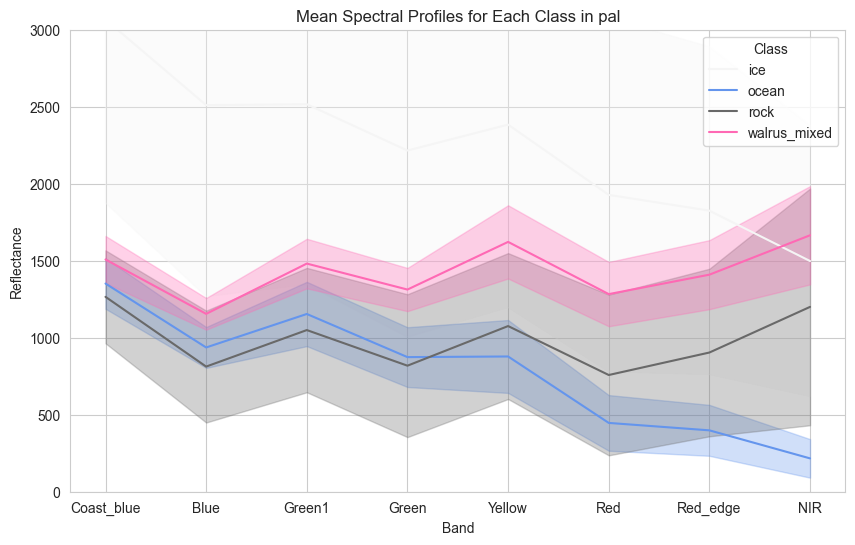

Processing island: sars, number of samples: 149151
Label rock not found in island sars
Label freshwater not found in island sars
Label walrus_pure not found in island sars


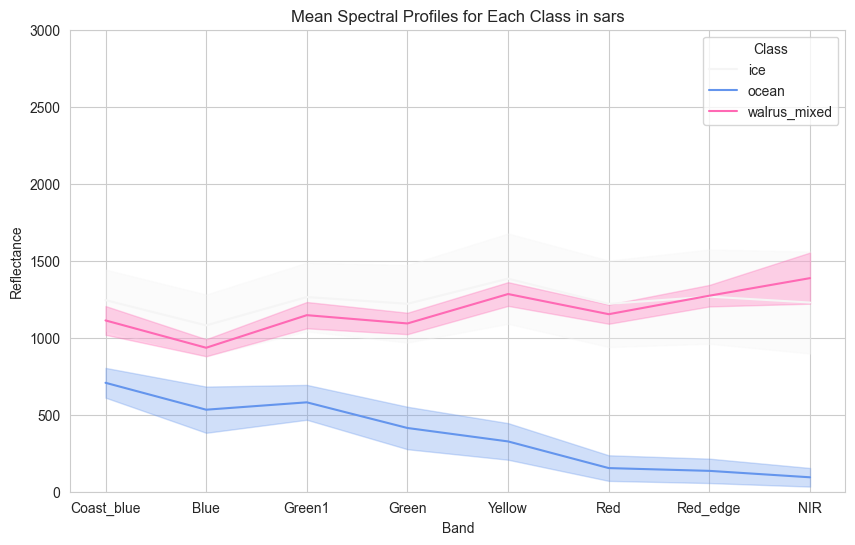

Processing island: tor, number of samples: 272659


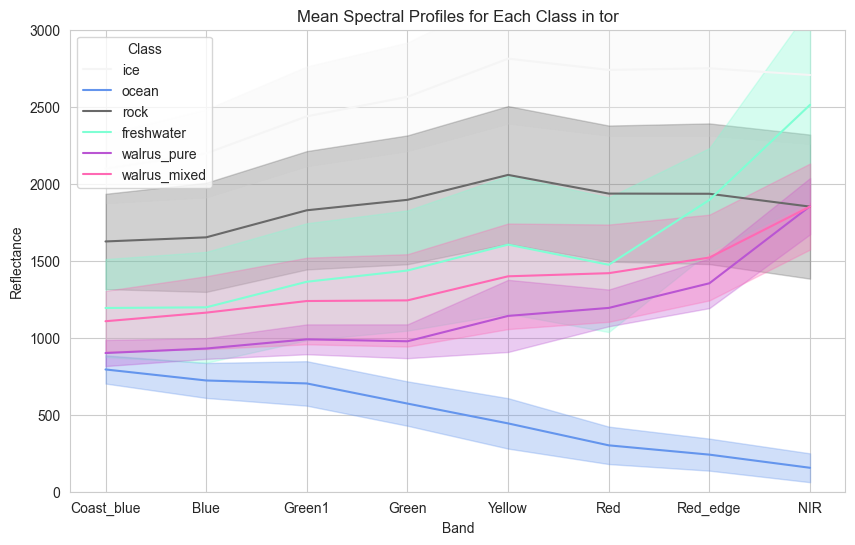

In [5]:
# Drop non-numeric columns before calculating mean and std
numeric_dataset = dataset.drop(columns=['labels', 'image_name'])

# Calculate mean and standard deviation for spectral profile for each class across all islands
mean_spectral_profiles = numeric_dataset.groupby('encoded_labels').mean()
std_spectral_profiles = numeric_dataset.groupby('encoded_labels').std()

# Plot mean spectral profiles with custom colors and error regions
plt.figure(figsize=(10, 6))
for label, color in custom_colors.items():
    if label in le.classes_:
        label_index = le.transform([label])[0]
        mean_values = mean_spectral_profiles.loc[label_index]
        std_values = std_spectral_profiles.loc[label_index]
        plt.plot(mean_values.index, mean_values, label=label, color=color)
        plt.fill_between(mean_values.index, mean_values - std_values, mean_values + std_values, color=color, alpha=0.3)
plt.title('Mean Spectral Profiles for Each Class Across All Islands')
plt.xlabel('Band')
plt.ylabel('Reflectance')
plt.legend(title='Class')
plt.show()

# Calculate mean and standard deviation for spectral profile for each class per island
islands = dataset['image_name'].apply(lambda x: extract_island_and_date(x)[0]).unique()

# Add debug prints
print(f"Islands found: {islands}")

for island in islands:
    island_data = dataset[dataset['image_name'].apply(lambda x: extract_island_and_date(x)[0]) == island]
    print(f"Processing island: {island}, number of samples: {len(island_data)}")
    
    if len(island_data) == 0:
        continue
    
    numeric_island_data = island_data.drop(columns=['labels', 'image_name'])
    mean_spectral_profiles_island = numeric_island_data.groupby('encoded_labels').mean()
    std_spectral_profiles_island = numeric_island_data.groupby('encoded_labels').std()
    
    # Plot mean spectral profiles for each island with custom colors and error regions
    plt.figure(figsize=(10, 6))
    for label, color in custom_colors.items():
        if label in le.classes_:
            label_index = le.transform([label])[0]
            if label_index in mean_spectral_profiles_island.index:
                mean_values = mean_spectral_profiles_island.loc[label_index]
                std_values = std_spectral_profiles_island.loc[label_index]
                plt.plot(mean_values.index, mean_values, label=label, color=color)
                plt.fill_between(mean_values.index, mean_values - std_values, mean_values + std_values, color=color, alpha=0.3)
            else:
                print(f"Label {label} not found in island {island}")
    plt.title(f'Mean Spectral Profiles for Each Class in {island}')
    plt.xlabel('Band')
    plt.ylabel('Reflectance')
    plt.legend(title='Class')
    plt.ylim(0, 3000)  # Adjust
    plt.show()

In [2]:
# Define the directories containing images and shapefiles
image_dir = "C:\\Users\\Student\\Documents\\101_walrus_data\\train\\clipped_images"
shapefile_dir = "C:\\Users\\Student\\Documents\\101_walrus_data\\train\\clipped_train"
unlabeled_image_dir = "C:\\Users\\Student\\Documents\\101_walrus_data\\train\\clipped_unlabeled"

# Use glob to list all .tif and .shp files in the specified directories
image_paths = glob.glob(f"{image_dir}/*.tif")
shapefile_paths = glob.glob(f"{shapefile_dir}/*.shp")
unlabeled_image_paths = glob.glob(f"{unlabeled_image_dir}/*.tif")

# Function to extract island name and date from file names
def extract_island_and_date(filename):
    pattern = r'([a-zA-Z]+)_(\d{8})'
    match = re.search(pattern, filename)
    if match:
        return match.group(1), match.group(2)
    return None, None

# Create a dictionary to store paired image and shapefile paths
file_pairs = {}

# Pair image and shapefile paths based on filenames
for image_path in image_paths:
    island, date = extract_island_and_date(os.path.basename(image_path))
    if island is None or date is None:
        print(f"Failed to extract island and date from {image_path}")
        continue

    matching_shapefiles = [shapefile for shapefile in shapefile_paths if island in shapefile and date in shapefile]
    if not matching_shapefiles:
        print(f"No matching shapefile found for {image_path}")
        continue

    shapefile_path = matching_shapefiles[0]
    file_pairs[image_path] = shapefile_path

# Function to extract features and labels
def extract_features_labels(image_path, shapefile_path):
    with rasterio.open(image_path) as src:
        image = src.read()
        transform = src.transform

    gdf = gpd.read_file(shapefile_path)
    features = []
    labels = []
    img_name = []

    for _, row in gdf.iterrows():
        mask = geometry_mask([row['geometry']], transform=transform, invert=True, out_shape=(src.height, src.width))
        feature_pixels = image[:, mask]
        label = row['label']

        for pixel in feature_pixels.T:  # Transpose to iterate over pixels
            features.append(pixel)
            labels.append(label)
            img_name.append(image_path)

    return np.array(features), np.array(labels), np.array(img_name)

features = []
labels = []
image_name = []

for image_path, shapefile_path in file_pairs.items():
    img_features, img_labels, img_name = extract_features_labels(image_path, shapefile_path)
    features.append(img_features)
    labels.append(img_labels)
    image_name.append(img_name)

features = np.vstack(features)
labels = np.hstack(labels)
image_name = np.hstack(image_name)
print(features, labels, image_name)

# Encode labels
le = LabelEncoder()
encoded_labels = le.fit_transform(labels)

# Create DataFrame
dataset = pd.DataFrame({'Coast_blue': features[:, 0],
                        'Blue': features[:, 1],
                        'Green1': features[:, 2],
                        'Green': features[:, 3],
                        'Yellow': features[:, 4],
                        'Red': features[:, 5],
                        'Red_edge': features[:, 6],
                        'NIR': features[:, 7],
                        'labels': labels,
                        'encoded_labels': encoded_labels,
                        'image_name': image_name})


No matching shapefile found for C:\Users\Student\Documents\101_walrus_data\train\clipped_images\pool_20230803_image.tif
[[1187  980 1269 ... 1329 1416 1650]
 [1148  912 1212 ... 1240 1297 1612]
 [1131  856 1162 ... 1181 1355 1510]
 ...
 [1730 1870 1929 ... 2091 2276 2647]
 [1634 1851 1879 ... 2053 2281 2634]
 [1720 1904 1905 ... 2135 2316 2654]] ['walrus_mixed' 'walrus_mixed' 'walrus_mixed' ... 'freshwater'
 'freshwater' 'freshwater'] ['C:\\Users\\Student\\Documents\\101_walrus_data\\train\\clipped_images\\buch_20230714_image.tif'
 'C:\\Users\\Student\\Documents\\101_walrus_data\\train\\clipped_images\\buch_20230714_image.tif'
 'C:\\Users\\Student\\Documents\\101_walrus_data\\train\\clipped_images\\buch_20230714_image.tif'
 ...
 'C:\\Users\\Student\\Documents\\101_walrus_data\\train\\clipped_images\\tor_20230902_image.tif'
 'C:\\Users\\Student\\Documents\\101_walrus_data\\train\\clipped_images\\tor_20230902_image.tif'
 'C:\\Users\\Student\\Documents\\101_walrus_data\\train\\clipped_ima

In [3]:
# Filter dataset for walrus_pure and walrus_mixed
walrus_classes = ['walrus_pure', 'walrus_mixed']
walrus_dataset = dataset[dataset['labels'].isin(walrus_classes)]

# Define custom colors for the walrus classes
custom_colors = {
    'walrus_pure': 'mediumorchid',
    'walrus_mixed': 'hotpink'
}

# Get unique islands
islands = walrus_dataset['image_name'].apply(lambda x: extract_island_and_date(x)[0]).unique()

# Add debug prints
print(f"Islands found: {islands}")

Islands found: ['buch' 'moff' 'pal' 'sars' 'tor']


Processing island: buch, number of samples: 190
Label walrus_pure not found in island buch


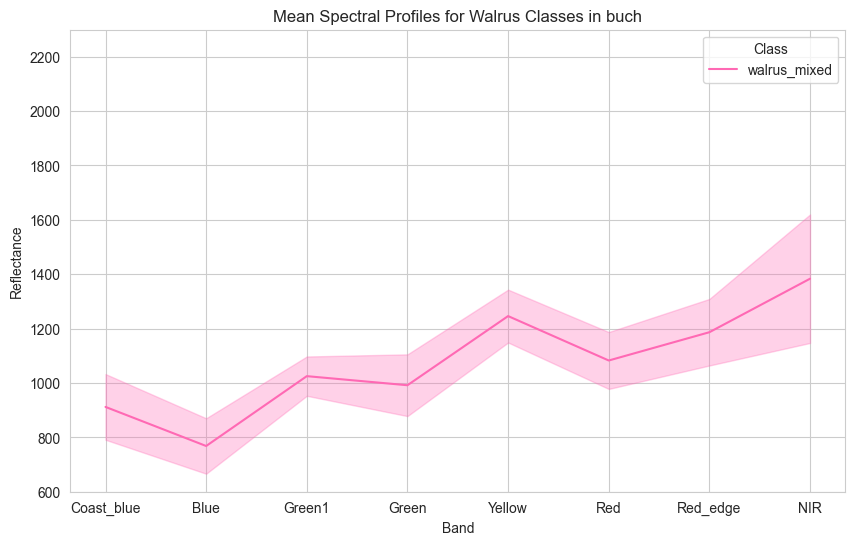

Processing island: moff, number of samples: 44
Label walrus_pure not found in island moff


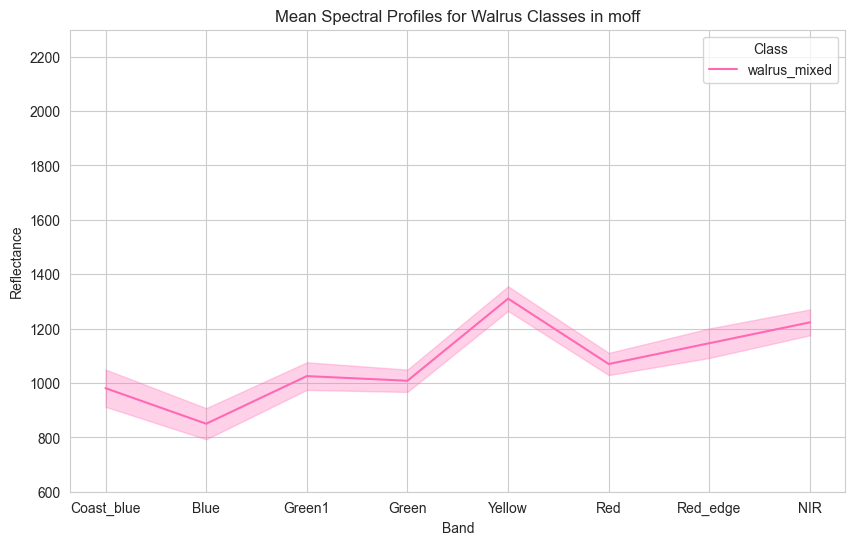

Processing island: pal, number of samples: 234
Label walrus_pure not found in island pal


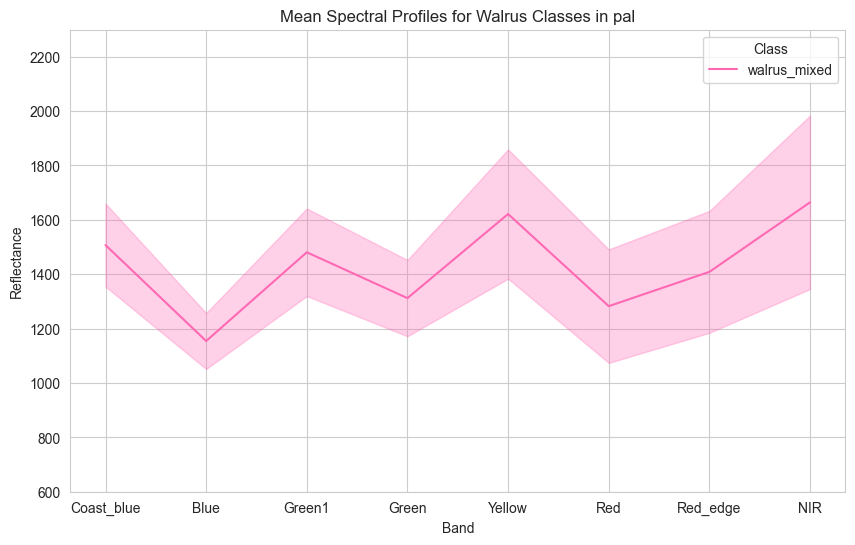

Processing island: sars, number of samples: 131
Label walrus_pure not found in island sars


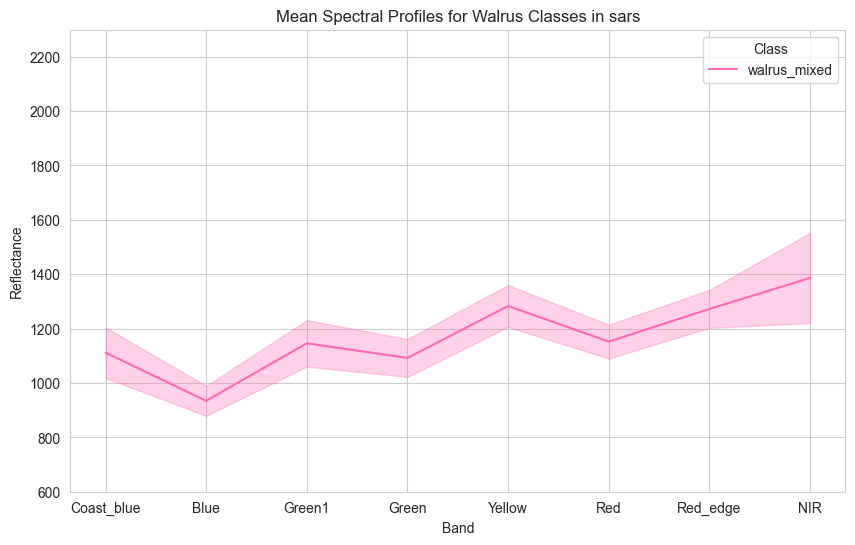

Processing island: tor, number of samples: 271


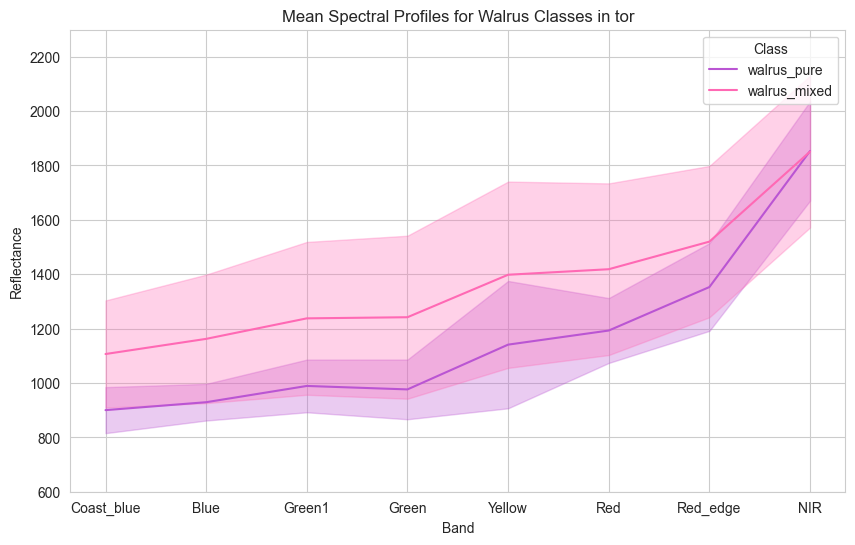

In [14]:
for island in islands:
    island_data = walrus_dataset[walrus_dataset['image_name'].apply(lambda x: extract_island_and_date(x)[0]) == island]
    print(f"Processing island: {island}, number of samples: {len(island_data)}")
    
    if len(island_data) == 0:
        continue
    
    numeric_island_data = island_data.drop(columns=['labels', 'image_name'])
    mean_spectral_profiles_island = numeric_island_data.groupby('encoded_labels').mean()
    std_spectral_profiles_island = numeric_island_data.groupby('encoded_labels').std()
    
    # Plot mean spectral profiles for each island with custom colors and error regions
    plt.figure(figsize=(10, 6))
    for label, color in custom_colors.items():
        if label in le.classes_:
            label_index = le.transform([label])[0]
            if label_index in mean_spectral_profiles_island.index:
                mean_values = mean_spectral_profiles_island.loc[label_index]
                std_values = std_spectral_profiles_island.loc[label_index]
                plt.plot(mean_values.index, mean_values, label=label, color=color)
                plt.fill_between(mean_values.index, mean_values - std_values, mean_values + std_values, color=color, alpha=0.3)
            else:
                print(f"Label {label} not found in island {island}")
    plt.title(f'Mean Spectral Profiles for Walrus Classes in {island}')
    plt.xlabel('Band')
    plt.ylabel('Reflectance')
    plt.legend(title='Class')
    plt.ylim(600, 2300)  # Adjust as needed
    plt.show()

C:\Users\Student\AppData\Local\Temp\ipykernel_12136\3716602485.py:16: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = plt.cm.get_cmap('tab10', len(islands))


Processing island: buch, number of samples: 190
Processing island: moff, number of samples: 44
Processing island: pal, number of samples: 234
Processing island: sars, number of samples: 131
Processing island: tor, number of samples: 271


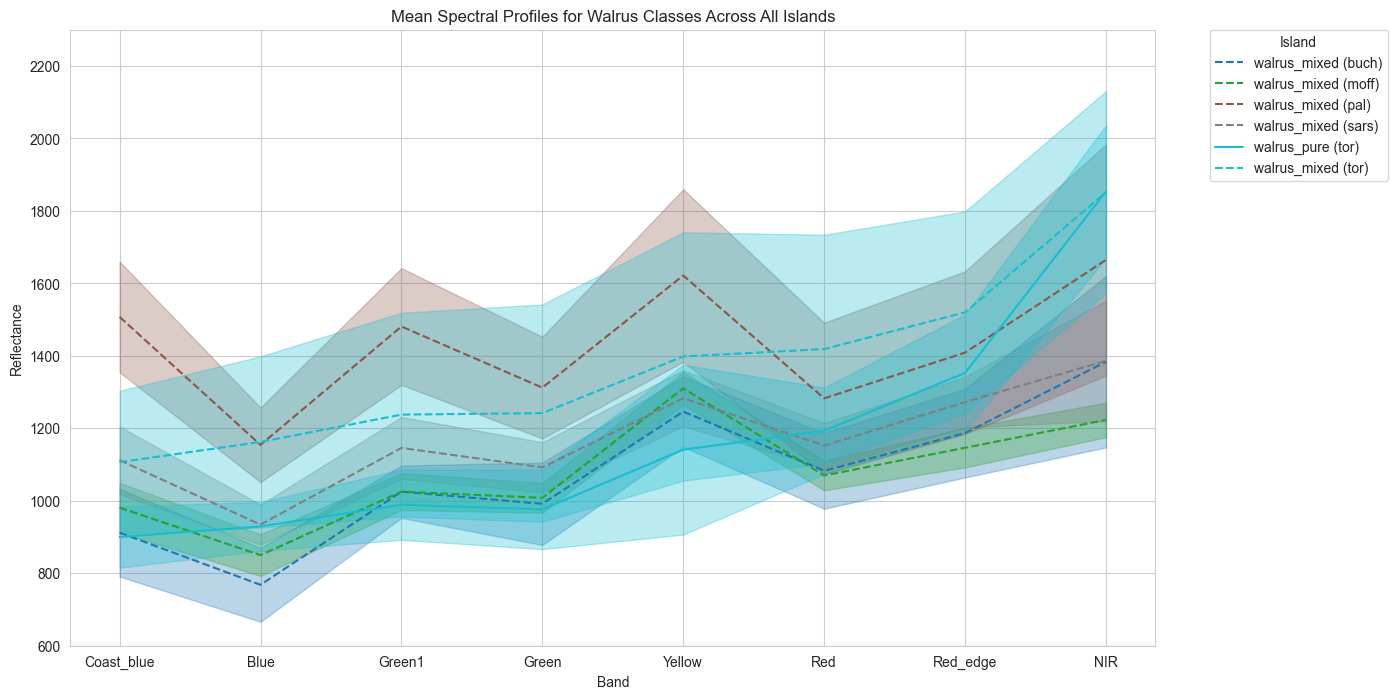

In [13]:
# Filter dataset for walrus_pure and walrus_mixed
walrus_classes = ['walrus_pure', 'walrus_mixed']
walrus_dataset = dataset[dataset['labels'].isin(walrus_classes)]

# Get unique islands
islands = walrus_dataset['image_name'].apply(lambda x: extract_island_and_date(x)[0]).unique()

# Define line styles for walrus classes
line_styles = {
    'walrus_pure': 'solid',
    'walrus_mixed': 'dashed'
}

# Plot mean spectral profiles for all islands in one plot
plt.figure(figsize=(14, 8))
colors = plt.cm.get_cmap('tab10', len(islands))

for i, island in enumerate(islands):
    island_data = walrus_dataset[walrus_dataset['image_name'].apply(lambda x: extract_island_and_date(x)[0]) == island]
    print(f"Processing island: {island}, number of samples: {len(island_data)}")
    
    if len(island_data) == 0:
        continue
    
    numeric_island_data = island_data.drop(columns=['labels', 'image_name'])
    mean_spectral_profiles_island = numeric_island_data.groupby('encoded_labels').mean()
    std_spectral_profiles_island = numeric_island_data.groupby('encoded_labels').std()
    
    for label in walrus_classes:
        if label in le.classes_:
            label_index = le.transform([label])[0]
            if label_index in mean_spectral_profiles_island.index:
                mean_values = mean_spectral_profiles_island.loc[label_index]
                std_values = std_spectral_profiles_island.loc[label_index]
                plt.plot(mean_values.index, mean_values, label=f'{label} ({island})', color=colors(i), linestyle=line_styles[label])
                plt.fill_between(mean_values.index, mean_values - std_values, mean_values + std_values, color=colors(i), alpha=0.3)

plt.title('Mean Spectral Profiles for Walrus Classes Across All Islands')
plt.xlabel('Band')
plt.ylabel('Reflectance')
plt.legend(title='Island', bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
plt.ylim(600, 2300)  # Adjust as needed
plt.show()


C:\Users\Student\AppData\Local\Temp\ipykernel_12136\3115775451.py:10: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = plt.cm.get_cmap('tab10', len(islands))


Processing island (walrus_pure): buch, number of samples: 0
Processing island (walrus_pure): moff, number of samples: 0
Processing island (walrus_pure): pal, number of samples: 0
Processing island (walrus_pure): sars, number of samples: 0
Processing island (walrus_pure): tor, number of samples: 48


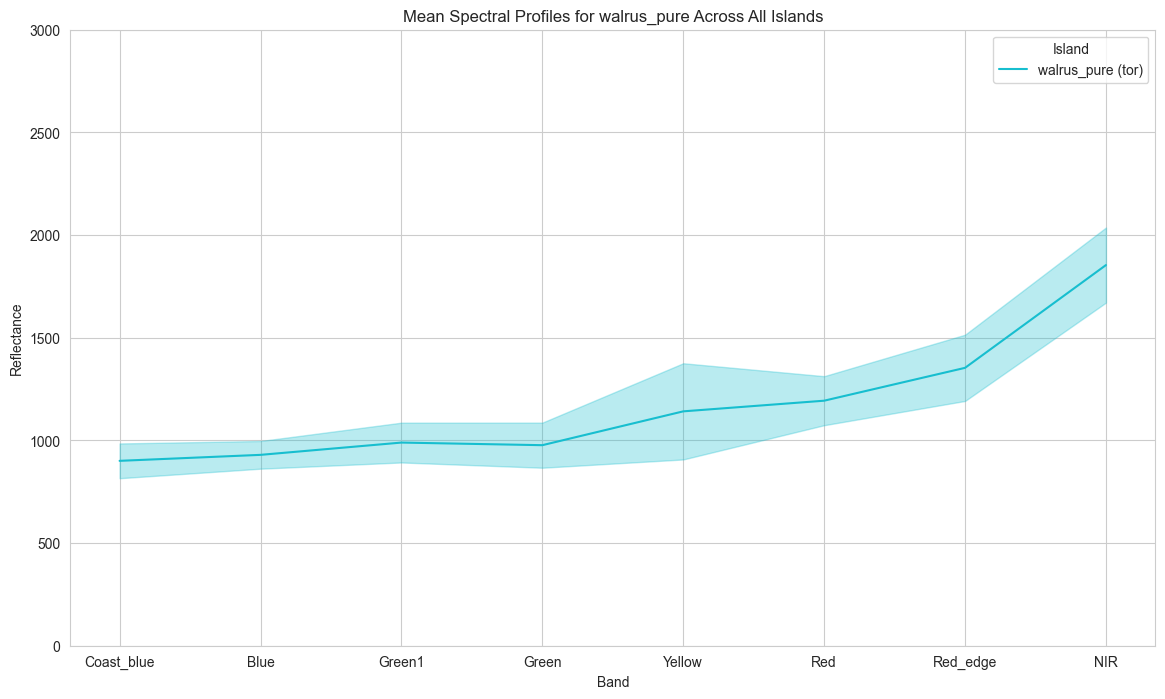

C:\Users\Student\AppData\Local\Temp\ipykernel_12136\3115775451.py:40: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = plt.cm.get_cmap('tab10', len(islands))


Processing island (walrus_mixed): buch, number of samples: 190
Processing island (walrus_mixed): moff, number of samples: 44
Processing island (walrus_mixed): pal, number of samples: 234
Processing island (walrus_mixed): sars, number of samples: 131
Processing island (walrus_mixed): tor, number of samples: 223


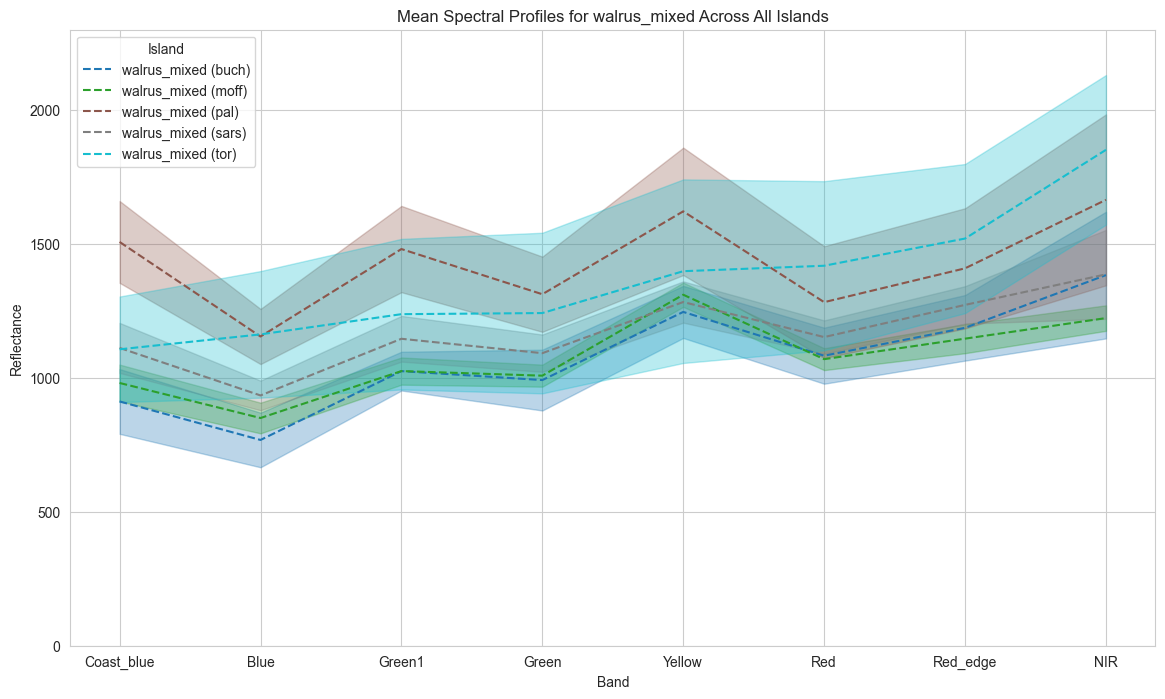

In [9]:
# Filter dataset for walrus_pure and walrus_mixed
walrus_classes = ['walrus_pure', 'walrus_mixed']
walrus_dataset = dataset[dataset['labels'].isin(walrus_classes)]

# Get unique islands
islands = walrus_dataset['image_name'].apply(lambda x: extract_island_and_date(x)[0]).unique()

# Plot for walrus_pure
plt.figure(figsize=(14, 8))
colors = plt.cm.get_cmap('tab10', len(islands))

for i, island in enumerate(islands):
    island_data = walrus_dataset[(walrus_dataset['image_name'].apply(lambda x: extract_island_and_date(x)[0]) == island) & 
                                 (walrus_dataset['labels'] == 'walrus_pure')]
    print(f"Processing island (walrus_pure): {island}, number of samples: {len(island_data)}")
    
    if len(island_data) == 0:
        continue
    
    numeric_island_data = island_data.drop(columns=['labels', 'image_name'])
    mean_spectral_profiles_island = numeric_island_data.groupby('encoded_labels').mean()
    std_spectral_profiles_island = numeric_island_data.groupby('encoded_labels').std()
    
    label_index = le.transform(['walrus_pure'])[0]
    if label_index in mean_spectral_profiles_island.index:
        mean_values = mean_spectral_profiles_island.loc[label_index]
        std_values = std_spectral_profiles_island.loc[label_index]
        plt.plot(mean_values.index, mean_values, label=f'walrus_pure ({island})', color=colors(i), linestyle='solid')
        plt.fill_between(mean_values.index, mean_values - std_values, mean_values + std_values, color=colors(i), alpha=0.3)

plt.title('Mean Spectral Profiles for walrus_pure Across All Islands')
plt.xlabel('Band')
plt.ylabel('Reflectance')
plt.legend(title='Island')
plt.ylim(0, 3000)  # Adjust as needed
plt.show()

# Plot for walrus_mixed
plt.figure(figsize=(14, 8))
colors = plt.cm.get_cmap('tab10', len(islands))

for i, island in enumerate(islands):
    island_data = walrus_dataset[(walrus_dataset['image_name'].apply(lambda x: extract_island_and_date(x)[0]) == island) & 
                                 (walrus_dataset['labels'] == 'walrus_mixed')]
    print(f"Processing island (walrus_mixed): {island}, number of samples: {len(island_data)}")
    
    if len(island_data) == 0:
        continue
    
    numeric_island_data = island_data.drop(columns=['labels', 'image_name'])
    mean_spectral_profiles_island = numeric_island_data.groupby('encoded_labels').mean()
    std_spectral_profiles_island = numeric_island_data.groupby('encoded_labels').std()
    
    label_index = le.transform(['walrus_mixed'])[0]
    if label_index in mean_spectral_profiles_island.index:
        mean_values = mean_spectral_profiles_island.loc[label_index]
        std_values = std_spectral_profiles_island.loc[label_index]
        plt.plot(mean_values.index, mean_values, label=f'walrus_mixed ({island})', color=colors(i), linestyle='dashed')
        plt.fill_between(mean_values.index, mean_values - std_values, mean_values + std_values, color=colors(i), alpha=0.3)

plt.title('Mean Spectral Profiles for walrus_mixed Across All Islands')
plt.xlabel('Band')
plt.ylabel('Reflectance')
plt.legend(title='Island')
plt.ylim(0, 2300)  # Adjust as needed
plt.show()

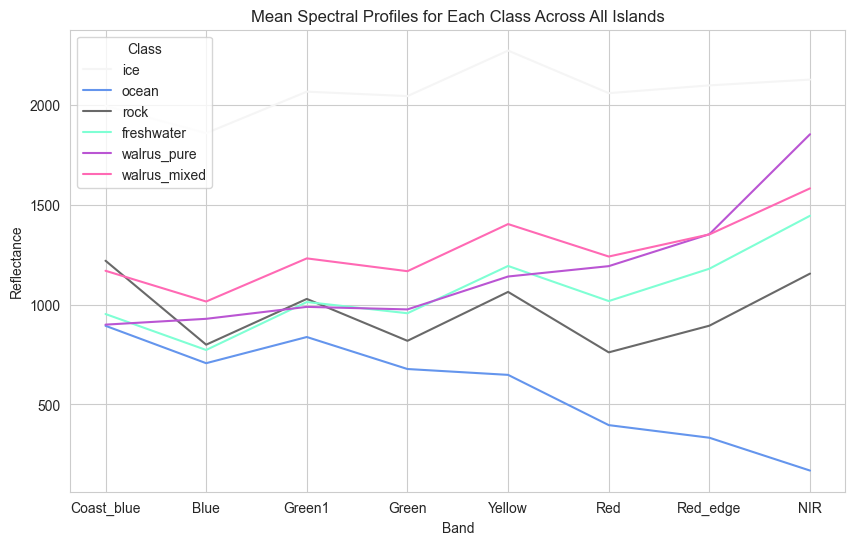

Islands found: ['buch' 'moff' 'pal' 'sars' 'tor']
Processing island: buch, number of samples: 553705
Label walrus_pure not found in island buch


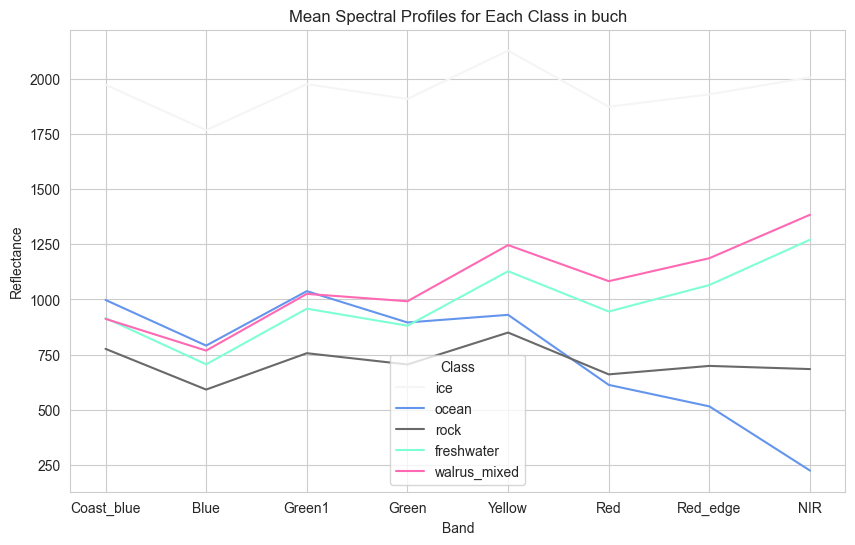

Processing island: moff, number of samples: 67507
Label rock not found in island moff
Label walrus_pure not found in island moff


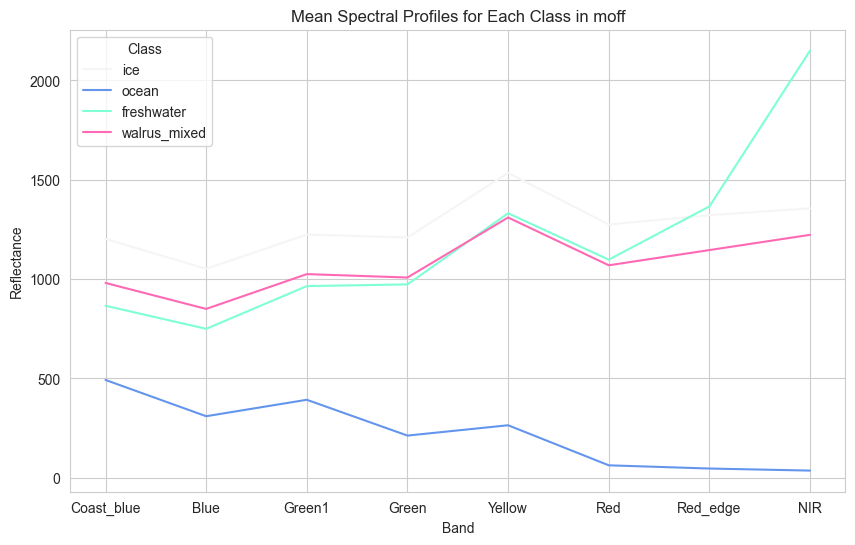

Processing island: pal, number of samples: 170474
Label freshwater not found in island pal
Label walrus_pure not found in island pal


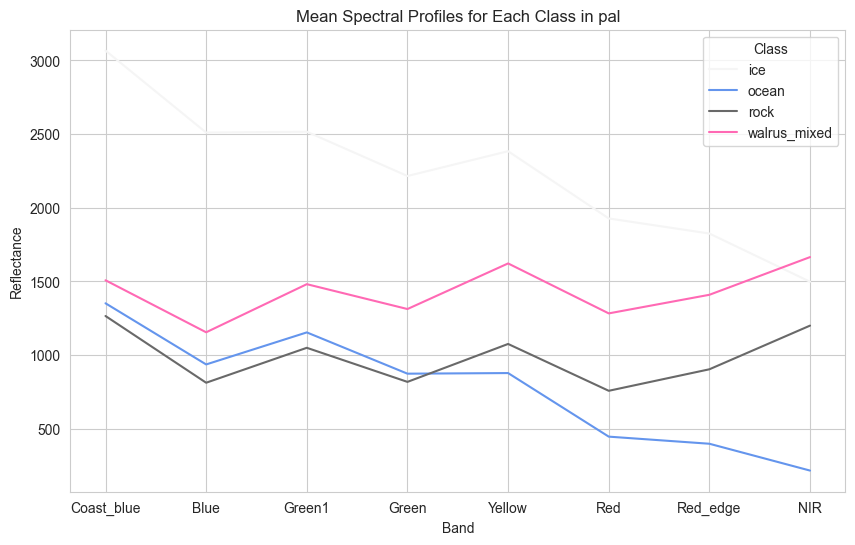

Processing island: sars, number of samples: 149151
Label rock not found in island sars
Label freshwater not found in island sars
Label walrus_pure not found in island sars


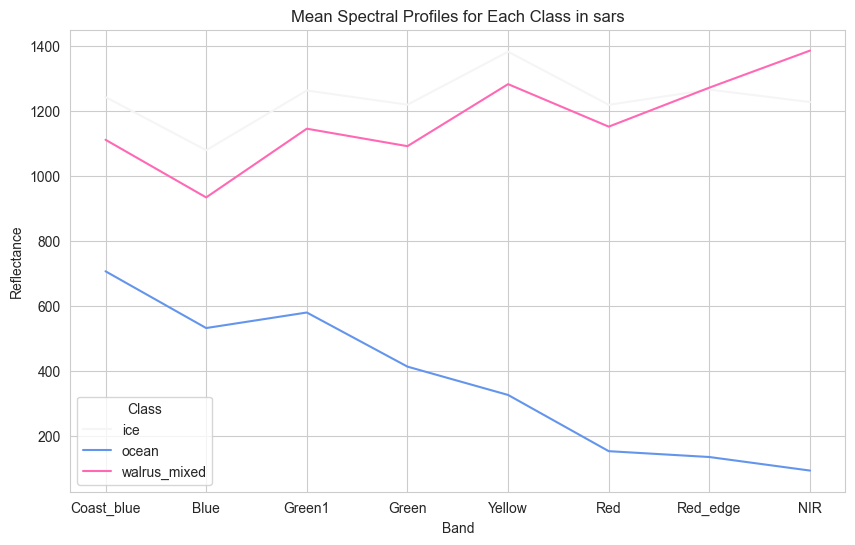

Processing island: tor, number of samples: 272659


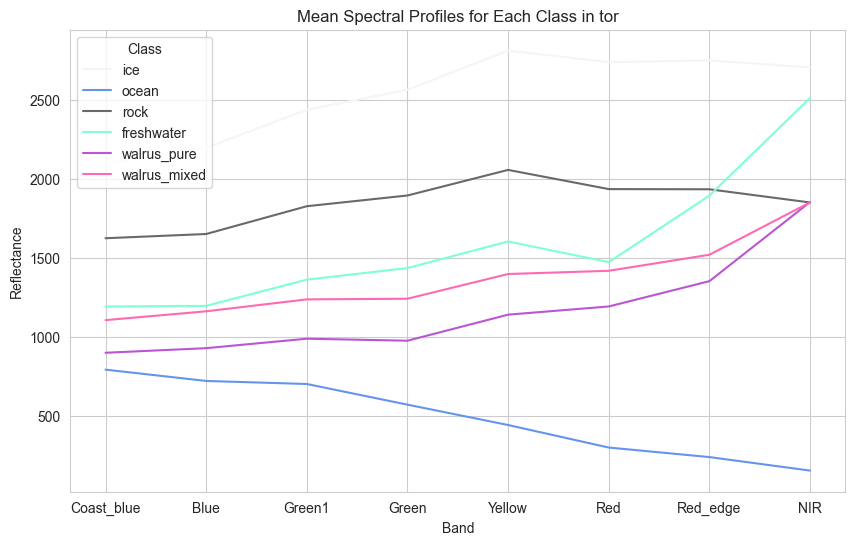

In [11]:
# Calculate mean spectral profile for each class across all islands
mean_spectral_profiles = numeric_dataset.groupby('encoded_labels').mean()

# Plot mean spectral profiles with custom colors
plt.figure(figsize=(10, 6))
for label, color in custom_colors.items():
    if label in le.classes_:
        plt.plot(mean_spectral_profiles.loc[le.transform([label])[0]], label=label, color=color)
plt.title('Mean Spectral Profiles for Each Class Across All Islands')
plt.xlabel('Band')
plt.ylabel('Reflectance')
plt.legend(title='Class')
plt.show()

# Calculate mean spectral profile for each class per island
islands = dataset['image_name'].apply(lambda x: extract_island_and_date(x)[0]).unique()

# Add debug prints
print(f"Islands found: {islands}")

for island in islands:
    island_data = dataset[dataset['image_name'].apply(lambda x: extract_island_and_date(x)[0]) == island]
    print(f"Processing island: {island}, number of samples: {len(island_data)}")
    
    if len(island_data) == 0:
        continue
    
    numeric_island_data = island_data.drop(columns=['labels', 'image_name'])
    mean_spectral_profiles_island = numeric_island_data.groupby('encoded_labels').mean()
    
    # Plot mean spectral profiles for each island with custom colors
    plt.figure(figsize=(10, 6))
    for label, color in custom_colors.items():
        if label in le.classes_:
            label_index = le.transform([label])[0]
            if label_index in mean_spectral_profiles_island.index:
                plt.plot(mean_spectral_profiles_island.loc[label_index], label=label, color=color)
            else:
                print(f"Label {label} not found in island {island}")
    plt.title(f'Mean Spectral Profiles for Each Class in {island}')
    plt.xlabel('Band')
    plt.ylabel('Reflectance')
    plt.legend(title='Class')
    plt.show()

In [20]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
from statsmodels.multivariate.manova import MANOVA
from scipy.stats import f_oneway
import itertools

In [23]:
# Prepare the data for MANOVA
bands = ['Coast_blue', 'Blue', 'Green1', 'Green', 'Yellow', 'Red', 'Red_edge', 'NIR']
manova_data = dataset[bands].copy()
manova_data.loc[:, 'encoded_labels'] = encoded_labels  # Fix the SettingWithCopyWarning

# Perform MANOVA
manova = MANOVA.from_formula('Coast_blue + Blue + Green1 + Green + Yellow + Red + Red_edge + NIR ~ C(encoded_labels)', data=manova_data)
manova_results = manova.mv_test()
print(manova_results)

# Access the overall significance from MANOVA
overall_p_value = manova_results.results['C(encoded_labels)']['stat'].iloc[0, -1]  # Get the 'Pr > F' value for 'Wilks' lambda'

if overall_p_value < 0.05:
    print("Overall MANOVA test is significant.")
    
    # Perform one-way ANOVA for each band and pairwise comparisons
    anova_results = {}
    pairwise_comparisons = {}
    
    for band in bands:
        # Perform one-way ANOVA
        fval, pval = f_oneway(*(manova_data[manova_data['encoded_labels'] == label][band] for label in np.unique(encoded_labels)))
        anova_results[band] = (fval, pval)
        print(f"ANOVA for {band}: F-value = {fval}, p-value = {pval}")
        
        # If ANOVA is significant, perform pairwise comparisons
        if pval < 0.05:
            pairwise_comparisons[band] = []
            unique_labels = np.unique(encoded_labels)
            for (label1, label2) in itertools.combinations(unique_labels, 2):
                group1 = manova_data[manova_data['encoded_labels'] == label1][band]
                group2 = manova_data[manova_data['encoded_labels'] == label2][band]
                tval, pval_pairwise, _ = sm.stats.ttest_ind(group1, group2)
                pairwise_comparisons[band].append((label1, label2, tval, pval_pairwise))
                print(f"Pairwise comparison for {band} between {le.inverse_transform([label1])[0]} and {le.inverse_transform([label2])[0]}: t-value = {tval}, p-value = {pval_pairwise}")

# Convert results to DataFrame for better visualization
anova_df = pd.DataFrame(anova_results, index=['F-value', 'p-value']).T
print(anova_df)

pairwise_df = {}
for band, comparisons in pairwise_comparisons.items():
    pairwise_df[band] = pd.DataFrame(comparisons, columns=['Class 1', 'Class 2', 't-value', 'p-value'])
    print(f"\nPairwise comparisons for {band}:")
    print(pairwise_df[band])


                      Multivariate linear model
                                                                      
----------------------------------------------------------------------
         Intercept        Value  Num DF    Den DF     F Value   Pr > F
----------------------------------------------------------------------
            Wilks' lambda 0.7049 8.0000 1213483.0000 63489.4851 0.0000
           Pillai's trace 0.2951 8.0000 1213483.0000 63489.4851 0.0000
   Hotelling-Lawley trace 0.4186 8.0000 1213483.0000 63489.4851 0.0000
      Roy's greatest root 0.4186 8.0000 1213483.0000 63489.4851 0.0000
----------------------------------------------------------------------
                                                                      
----------------------------------------------------------------------
   C(encoded_labels)    Value   Num DF    Den DF      F Value   Pr > F
----------------------------------------------------------------------
          Wilks' lambda 0.135

In [24]:
if overall_p_value < 0.05:
    print("Overall MANOVA test is significant.")
    
    # Perform one-way ANOVA for each band and pairwise comparisons
    anova_results = {}
    pairwise_comparisons = {}
    
    for band in bands:
        # Perform one-way ANOVA
        fval, pval = f_oneway(*(manova_data[manova_data['encoded_labels'] == label][band] for label in np.unique(encoded_labels)))
        
        # Store only significant ANOVA results
        if pval < 0.05:
            anova_results[band] = (fval, pval)
            print(f"ANOVA for {band}: F-value = {fval}, p-value = {pval}")
        
            # Perform pairwise comparisons if ANOVA is significant
            pairwise_comparisons[band] = []
            unique_labels = np.unique(encoded_labels)
            for (label1, label2) in itertools.combinations(unique_labels, 2):
                group1 = manova_data[manova_data['encoded_labels'] == label1][band]
                group2 = manova_data[manova_data['encoded_labels'] == label2][band]
                tval, pval_pairwise, _ = sm.stats.ttest_ind(group1, group2)
                
                # Store only significant pairwise comparison results
                if pval_pairwise < 0.05:
                    pairwise_comparisons[band].append((label1, label2, tval, pval_pairwise))
                    print(f"Pairwise comparison for {band} between {le.inverse_transform([label1])[0]} and {le.inverse_transform([label2])[0]}: t-value = {tval}, p-value = {pval_pairwise}")

# Convert significant ANOVA results to DataFrame for better visualization
anova_df = pd.DataFrame(anova_results, index=['F-value', 'p-value']).T
print("\nSignificant ANOVA results:")
print(anova_df)

pairwise_df = {}
for band, comparisons in pairwise_comparisons.items():
    if comparisons:
        pairwise_df[band] = pd.DataFrame(comparisons, columns=['Class 1', 'Class 2', 't-value', 'p-value'])
        print(f"\nSignificant pairwise comparisons for {band}:")
        print(pairwise_df[band])


Overall MANOVA test is significant.
ANOVA for Coast_blue: F-value = 75771.22491384506, p-value = 0.0
Pairwise comparison for Coast_blue between freshwater and ice: t-value = -132.18169081534398, p-value = 0.0
Pairwise comparison for Coast_blue between freshwater and ocean: t-value = 33.23462806115899, p-value = 4.9409503907161835e-242
Pairwise comparison for Coast_blue between freshwater and rock: t-value = -113.15609431928547, p-value = 0.0
Pairwise comparison for Coast_blue between freshwater and walrus_mixed: t-value = -12.029947765796798, p-value = 2.8135328362395777e-33
Pairwise comparison for Coast_blue between ice and ocean: t-value = 585.0902793990523, p-value = 0.0
Pairwise comparison for Coast_blue between ice and rock: t-value = 149.3756501271855, p-value = 0.0
Pairwise comparison for Coast_blue between ice and walrus_mixed: t-value = 15.06958196239899, p-value = 2.6806096280391026e-51
Pairwise comparison for Coast_blue between ice and walrus_pure: t-value = 4.83206249422251

In [26]:
from scipy.stats import ttest_ind

In [27]:
# T test 

# Prepare the data
bands = ['Coast_blue', 'Blue', 'Green1', 'Green', 'Yellow', 'Red', 'Red_edge', 'NIR']
manova_data = dataset[bands].copy()
manova_data.loc[:, 'encoded_labels'] = encoded_labels  # Fix the SettingWithCopyWarning

# Dictionary to store pairwise comparisons
pairwise_comparisons = {}

# Perform pairwise comparisons for each band
for band in bands:
    pairwise_comparisons[band] = []
    unique_labels = np.unique(encoded_labels)
    for (label1, label2) in itertools.combinations(unique_labels, 2):
        group1 = manova_data[manova_data['encoded_labels'] == label1][band]
        group2 = manova_data[manova_data['encoded_labels'] == label2][band]
        tval, pval = ttest_ind(group1, group2)
        
        # Store all pairwise comparison results
        pairwise_comparisons[band].append((label1, label2, tval, pval))
        class1_name = le.inverse_transform([label1])[0]
        class2_name = le.inverse_transform([label2])[0]
        print(f"Pairwise comparison for {band} between {class1_name} and {class2_name}: t-value = {tval}, p-value = {pval}")

# Convert all pairwise comparisons to DataFrames for better visualization
pairwise_df = {}
for band, comparisons in pairwise_comparisons.items():
    if comparisons:
        pairwise_df[band] = pd.DataFrame(comparisons, columns=['Class 1', 'Class 2', 't-value', 'p-value'])
        pairwise_df[band]['Class 1'] = le.inverse_transform(pairwise_df[band]['Class 1'])
        pairwise_df[band]['Class 2'] = le.inverse_transform(pairwise_df[band]['Class 2'])
        print(f"\nPairwise comparisons for {band}:")
        print(pairwise_df[band])


Pairwise comparison for Coast_blue between freshwater and ice: t-value = -132.18169081534398, p-value = 0.0
Pairwise comparison for Coast_blue between freshwater and ocean: t-value = 33.23462806115898, p-value = 4.940950390718996e-242
Pairwise comparison for Coast_blue between freshwater and rock: t-value = -113.15609431928547, p-value = 0.0
Pairwise comparison for Coast_blue between freshwater and walrus_mixed: t-value = -12.029947765796798, p-value = 2.8135328362395777e-33
Pairwise comparison for Coast_blue between freshwater and walrus_pure: t-value = 0.7159079587534505, p-value = 0.47405233211822484
Pairwise comparison for Coast_blue between ice and ocean: t-value = 585.0902793990523, p-value = 0.0
Pairwise comparison for Coast_blue between ice and rock: t-value = 149.3756501271855, p-value = 0.0
Pairwise comparison for Coast_blue between ice and walrus_mixed: t-value = 15.06958196239899, p-value = 2.6806096280391026e-51
Pairwise comparison for Coast_blue between ice and walrus_pur

DIDNT ACOUNT FOR THE VOILATION OF EQUAL VARIENCE - CANT USE THOSE TESTS AAAAAAAHHHHHHH

In [29]:
# Prepare the data
bands = ['Coast_blue', 'Blue', 'Green1', 'Green', 'Yellow', 'Red', 'Red_edge', 'NIR']
manova_data = dataset[bands + ['encoded_labels']].copy()  # Include encoded_labels in the copy

# Function to get balanced samples
def get_balanced_samples(data, label_column, size):
    sampled_data = []
    unique_labels = data[label_column].unique()
    for label in unique_labels:
        class_data = data[data[label_column] == label]
        if len(class_data) > size:
            class_data = class_data.sample(n=size, random_state=42)
        sampled_data.append(class_data)
    return pd.concat(sampled_data)

# Determine the minimum sample size across classes
min_sample_size = manova_data['encoded_labels'].value_counts().min()

# Perform pairwise comparisons for each band using balanced samples
pairwise_comparisons = {}
for band in bands:
    pairwise_comparisons[band] = []
    unique_labels = manova_data['encoded_labels'].unique()
    for (label1, label2) in itertools.combinations(unique_labels, 2):
        balanced_data = get_balanced_samples(manova_data, 'encoded_labels', min_sample_size)
        group1 = balanced_data[balanced_data['encoded_labels'] == label1][band]
        group2 = balanced_data[balanced_data['encoded_labels'] == label2][band]
        tval, pval = ttest_ind(group1, group2, equal_var=False)  # Use Welch's t-test
        
        # Store all pairwise comparison results
        pairwise_comparisons[band].append((label1, label2, tval, pval))
        class1_name = le.inverse_transform([label1])[0]
        class2_name = le.inverse_transform([label2])[0]
        print(f"Pairwise comparison for {band} between {class1_name} and {class2_name}: t-value = {tval}, p-value = {pval}")

# Convert all pairwise comparisons to DataFrames for better visualisation
pairwise_df = {}
for band, comparisons in pairwise_comparisons.items():
    if comparisons:
        pairwise_df[band] = pd.DataFrame(comparisons, columns=['Class 1', 'Class 2', 't-value', 'p-value'])
        pairwise_df[band]['Class 1'] = le.inverse_transform(pairwise_df[band]['Class 1'])
        pairwise_df[band]['Class 2'] = le.inverse_transform(pairwise_df[band]['Class 2'])
        print(f"\nPairwise comparisons for {band}:")
        print(pairwise_df[band])

Pairwise comparison for Coast_blue between walrus_mixed and ocean: t-value = 2.84614499028317, p-value = 0.0055736875150430715
Pairwise comparison for Coast_blue between walrus_mixed and rock: t-value = -0.3266657411012897, p-value = 0.7446581021724895
Pairwise comparison for Coast_blue between walrus_mixed and freshwater: t-value = 5.911098738679769, p-value = 5.4782541672657045e-08
Pairwise comparison for Coast_blue between walrus_mixed and ice: t-value = -2.768264209721392, p-value = 0.007820236882494941
Pairwise comparison for Coast_blue between walrus_mixed and walrus_pure: t-value = 6.6654311457216115, p-value = 1.4128254861237092e-08
Pairwise comparison for Coast_blue between ocean and rock: t-value = -3.206435451081624, p-value = 0.0019562643798771502
Pairwise comparison for Coast_blue between ocean and freshwater: t-value = 1.7625062124626143, p-value = 0.08179723465697766
Pairwise comparison for Coast_blue between ocean and ice: t-value = -3.736400997182966, p-value = 0.00043

In [30]:
# Prepare the data
bands = ['Coast_blue', 'Blue', 'Green1', 'Green', 'Yellow', 'Red', 'Red_edge', 'NIR']
manova_data = dataset[bands].copy()
manova_data.loc[:, 'encoded_labels'] = encoded_labels  # Fix the SettingWithCopyWarning

# Dictionary to store pairwise comparisons
pairwise_comparisons = {}

# Perform pairwise comparisons for each band using Welch's t-test
for band in bands:
    pairwise_comparisons[band] = []
    unique_labels = np.unique(encoded_labels)
    for (label1, label2) in itertools.combinations(unique_labels, 2):
        group1 = manova_data[manova_data['encoded_labels'] == label1][band]
        group2 = manova_data[manova_data['encoded_labels'] == label2][band]
        tval, pval = ttest_ind(group1, group2, equal_var=False)  # Welch's t-test
        
        # Store all pairwise comparison results
        pairwise_comparisons[band].append((label1, label2, tval, pval))
        class1_name = le.inverse_transform([label1])[0]
        class2_name = le.inverse_transform([label2])[0]
        print(f"Pairwise comparison for {band} between {class1_name} and {class2_name}: t-value = {tval}, p-value = {pval}")

# Convert all pairwise comparisons to DataFrames for better visualisation
pairwise_df = {}
for band, comparisons in pairwise_comparisons.items():
    if comparisons:
        pairwise_df[band] = pd.DataFrame(comparisons, columns=['Class 1', 'Class 2', 't-value', 'p-value'])
        pairwise_df[band]['Class 1'] = le.inverse_transform(pairwise_df[band]['Class 1'])
        pairwise_df[band]['Class 2'] = le.inverse_transform(pairwise_df[band]['Class 2'])
        print(f"\nPairwise comparisons for {band}:")
        print(pairwise_df[band])


Pairwise comparison for Coast_blue between freshwater and ice: t-value = -270.8893671027385, p-value = 0.0
Pairwise comparison for Coast_blue between freshwater and ocean: t-value = 22.742551779644824, p-value = 8.288129689506995e-114
Pairwise comparison for Coast_blue between freshwater and rock: t-value = -95.84667598871192, p-value = 0.0
Pairwise comparison for Coast_blue between freshwater and walrus_mixed: t-value = -22.096039472699076, p-value = 1.4470648107863848e-87
Pairwise comparison for Coast_blue between freshwater and walrus_pure: t-value = 4.258312763320908, p-value = 8.80337092400169e-05
Pairwise comparison for Coast_blue between ice and ocean: t-value = 380.82827478973894, p-value = 0.0
Pairwise comparison for Coast_blue between ice and rock: t-value = 252.92609970500297, p-value = 0.0
Pairwise comparison for Coast_blue between ice and walrus_mixed: t-value = 83.49413387440556, p-value = 0.0
Pairwise comparison for Coast_blue between ice and walrus_pure: t-value = 87.21

Equalizing Sample Sizes

How It Works:
This method involves resampling the data to ensure each class has an equal number of samples before performing statistical tests.
It aims to create a balanced dataset by sampling a fixed number of observations from each class, typically the size of the smallest class.

Pros:
It avoids biases that can result from having vastly different sample sizes across classes.
By equalizing the sample sizes, it ensures that each class is equally represented in the statistical tests.

Cons:
It can lead to a loss of information if the larger classes are heavily downsampled.
The results might be less stable if the resampling process leads to high variability between different runs (unless a fixed random seed is used).

When to Use:
Use this method when you suspect that class imbalance might be causing biased results.
It is particularly useful when you have sufficient data and can afford to downsample the larger classes without losing too much information.


Using Welch's t-test

How It Works:
Welch's t-test is designed to handle unequal variances and sample sizes between groups.
It does not assume that the groups being compared have the same variance, making it more robust in situations where this assumption does not hold.

Pros:
It is specifically designed to handle unequal variances and sample sizes, making it a good choice for imbalanced datasets.
No data is discarded or resampled, so the entire dataset is used.

Cons:
It may still be influenced by extreme class imbalances, particularly if one class is very small compared to others.
The test can be less intuitive to interpret when there are extreme differences in group sizes.

When to Use:
Use this method when you have imbalanced data and want to use the entire dataset without resampling.
It is a good choice when you want to ensure that the test's assumptions (equal variances) are not violated.

In [31]:
# Print number of pixels in each class across all islands
class_distribution = dataset['labels'].value_counts()
print("Number of pixels in each class across all islands:")
print(class_distribution)

# Print number of pixels in each class for each island
print("\nNumber of pixels in each class for each island:")
islands = dataset['image_name'].apply(lambda x: extract_island_and_date(x)[0]).unique()

for island in islands:
    island_data = dataset[dataset['image_name'].apply(lambda x: extract_island_and_date(x)[0]) == island]
    island_class_distribution = island_data['labels'].value_counts()
    print(f"\nIsland: {island}")
    print(island_class_distribution)

Number of pixels in each class across all islands:
labels
ocean           779288
ice             300231
rock             92856
freshwater       40251
walrus_mixed       822
walrus_pure         48
Name: count, dtype: int64

Number of pixels in each class for each island:

Island: buch
labels
ocean           313885
ice             195822
freshwater       34517
rock              9291
walrus_mixed       190
Name: count, dtype: int64

Island: moff
labels
ocean           55129
ice             12090
freshwater        244
walrus_mixed       44
Name: count, dtype: int64

Island: pal
labels
rock            82490
ocean           77962
ice              9788
walrus_mixed      234
Name: count, dtype: int64

Island: sars
labels
ocean           143231
ice               5789
walrus_mixed       131
Name: count, dtype: int64

Island: tor
labels
ocean           189081
ice              76742
freshwater        5490
rock              1075
walrus_mixed       223
walrus_pure         48
Name: count, dtype: int6

Welch's ANOVA can be applied directly to the imbalanced dataset:

In [34]:
# Function to perform Welch's ANOVA
def welchs_anova(data, dependent_var, independent_var):
    formula = f'{dependent_var} ~ C({independent_var})'
    model = ols(formula, data=data).fit()
    anova_table = sm.stats.anova_lm(model, typ=2, robust='hc3')
    print(anova_table)
    return model

# Apply Welch's ANOVA to each spectral band
for band in bands:
    print(f"\nWelch's ANOVA for {band}")
    model = welchs_anova(dataset, band, 'labels')

# Perform post-hoc tests if needed
comp = multi.MultiComparison(dataset[band], dataset['labels'])
post_hoc_res = comp.tukeyhsd()
print(post_hoc_res)



Welch's ANOVA for Coast_blue
                 sum_sq         df           F  PR(>F)
C(labels)  1.517929e+11        5.0  43400.1523     0.0
Residual   8.488411e+11  1213490.0         NaN     NaN

Welch's ANOVA for Blue
                 sum_sq         df             F  PR(>F)
C(labels)  1.108665e+11        5.0  39227.957861     0.0
Residual   6.859157e+11  1213490.0           NaN     NaN

Welch's ANOVA for Green1
                 sum_sq         df             F  PR(>F)
C(labels)  1.410607e+11        5.0  46444.281349     0.0
Residual   7.371230e+11  1213490.0           NaN     NaN

Welch's ANOVA for Green
                 sum_sq         df             F  PR(>F)
C(labels)  1.736515e+11        5.0  67021.644642     0.0
Residual   6.288246e+11  1213490.0           NaN     NaN

Welch's ANOVA for Yellow
                 sum_sq         df              F  PR(>F)
C(labels)  2.955012e+11        5.0  101620.885017     0.0
Residual   7.057364e+11  1213490.0            NaN     NaN

Welch's ANOVA fo

Non-Parametric - Kruskal-Wallis H Test

In [35]:
from scipy.stats import kruskal

In [36]:
# Function to perform Kruskal-Wallis H test
def kruskal_wallis_test(data, dependent_var, independent_var):
    groups = data[independent_var].unique()
    group_data = [data[data[independent_var] == group][dependent_var] for group in groups]
    stat, p_value = kruskal(*group_data)
    print(f"Kruskal-Wallis H test for {dependent_var}: H-statistic = {stat}, p-value = {p_value}")
    return stat, p_value

# Apply Kruskal-Wallis H test to each spectral band
for band in bands:
    print(f"\nKruskal-Wallis H test for {band}")
    kruskal_wallis_test(dataset, band, 'labels')



Kruskal-Wallis H test for Coast_blue
Kruskal-Wallis H test for Coast_blue: H-statistic = 396695.54089294106, p-value = 0.0

Kruskal-Wallis H test for Blue
Kruskal-Wallis H test for Blue: H-statistic = 382913.7400329306, p-value = 0.0

Kruskal-Wallis H test for Green1
Kruskal-Wallis H test for Green1: H-statistic = 401448.69158046786, p-value = 0.0

Kruskal-Wallis H test for Green
Kruskal-Wallis H test for Green: H-statistic = 495364.98787667963, p-value = 0.0

Kruskal-Wallis H test for Yellow
Kruskal-Wallis H test for Yellow: H-statistic = 603380.0017913427, p-value = 0.0

Kruskal-Wallis H test for Red
Kruskal-Wallis H test for Red: H-statistic = 665949.4517667058, p-value = 0.0

Kruskal-Wallis H test for Red_edge
Kruskal-Wallis H test for Red_edge: H-statistic = 723429.833556239, p-value = 0.0

Kruskal-Wallis H test for NIR
Kruskal-Wallis H test for NIR: H-statistic = 794831.4159363415, p-value = 0.0


Bootstrapping can be applied directly to the imbalanced dataset to estimate the confidence intervals for the difference in means:

In [38]:
# Function to perform bootstrapping
def bootstrap_mean_diff(data, group1, group2, band, n_iterations=1000):
    group1_data = data[data['labels'] == group1][band].values
    group2_data = data[data['labels'] == group2][band].values
    diffs = []
    for _ in range(n_iterations):
        resampled_group1 = np.random.choice(group1_data, size=len(group1_data), replace=True)
        resampled_group2 = np.random.choice(group2_data, size=len(group2_data), replace=True)
        diffs.append(np.mean(resampled_group1) - np.mean(resampled_group2))
    return np.percentile(diffs, [2.5, 97.5])

# Classes of interest
walrus_classes = ['walrus_pure', 'walrus_mixed']
other_classes = ['rock', 'ice', 'ocean', 'freshwater']

# Loop through all combinations and perform bootstrap tests
for walrus_class in walrus_classes:
    for other_class in other_classes:
        for band in bands:
            conf_int = bootstrap_mean_diff(dataset, walrus_class, other_class, band)
            print(f"95% confidence interval of the difference in means between {walrus_class} and {other_class} for {band}: {conf_int}")


95% confidence interval of the difference in means between walrus_pure and rock for Coast_blue: [-343.63586844 -294.78062349]
95% confidence interval of the difference in means between walrus_pure and rock for Blue: [110.29347565 147.44686006]
95% confidence interval of the difference in means between walrus_pure and rock for Green1: [-67.68152745 -14.0015695 ]
95% confidence interval of the difference in means between walrus_pure and rock for Green: [125.8616367  187.54348373]
95% confidence interval of the difference in means between walrus_pure and rock for Yellow: [ 18.00789973 139.7487665 ]
95% confidence interval of the difference in means between walrus_pure and rock for Red: [398.77478219 464.83306652]
95% confidence interval of the difference in means between walrus_pure and rock for Red_edge: [414.36533059 503.67687414]
95% confidence interval of the difference in means between walrus_pure and rock for NIR: [641.39444503 745.03892236]
95% confidence interval of the difference

Positive Intervals: If the entire confidence interval is positive, it indicates that the first group has a significantly higher mean reflectance than the second group for that band.


Negative Intervals: If the entire confidence interval is negative, it indicates that the first group has a significantly lower mean reflectance than the second group for that band.


Intervals Containing Zero: If the confidence interval includes zero, it suggests that there is no significant difference in the mean reflectance between the two groups for that band.

MANOVA can be used to determine if there are any statistically significant differences in the spectral profiles between the classes

In [39]:
import statsmodels.api as sm
from statsmodels.multivariate.manova import MANOVA

In [40]:
# Prepare the data
bands = ['Coast_blue', 'Blue', 'Green1', 'Green', 'Yellow', 'Red', 'Red_edge', 'NIR']
manova_data = dataset[bands + ['encoded_labels']].copy()

# Perform MANOVA
manova = MANOVA.from_formula('Coast_blue + Blue + Green1 + Green + Yellow + Red + Red_edge + NIR ~ C(encoded_labels)', data=manova_data)
manova_results = manova.mv_test()
print(manova_results)


                      Multivariate linear model
                                                                      
----------------------------------------------------------------------
         Intercept        Value  Num DF    Den DF     F Value   Pr > F
----------------------------------------------------------------------
            Wilks' lambda 0.7049 8.0000 1213483.0000 63489.4851 0.0000
           Pillai's trace 0.2951 8.0000 1213483.0000 63489.4851 0.0000
   Hotelling-Lawley trace 0.4186 8.0000 1213483.0000 63489.4851 0.0000
      Roy's greatest root 0.4186 8.0000 1213483.0000 63489.4851 0.0000
----------------------------------------------------------------------
                                                                      
----------------------------------------------------------------------
   C(encoded_labels)    Value   Num DF    Den DF      F Value   Pr > F
----------------------------------------------------------------------
          Wilks' lambda 0.135

Principal Component Analysis (PCA) and MANOVA on Principal Components
PCA can reduce the dimensionality of the spectral profiles while preserving their overall shape. Then apply MANOVA on the principal components to test for differences between classes.

In [41]:
import pandas as pd
from sklearn.decomposition import PCA
import statsmodels.api as sm
from statsmodels.multivariate.manova import MANOVA

In [42]:
# Perform PCA
pca = PCA(n_components=2)  # Reduce to 2 components for visualization, but you can use more components if needed
principal_components = pca.fit_transform(dataset[bands])
pca_df = pd.DataFrame(data=principal_components, columns=['PC1', 'PC2'])
pca_df['labels'] = dataset['labels']

# Perform MANOVA on the principal components
manova = MANOVA.from_formula('PC1 + PC2 ~ C(labels)', data=pca_df)
manova_results = manova.mv_test()
print(manova_results)


                      Multivariate linear model
                                                                      
----------------------------------------------------------------------
         Intercept        Value  Num DF    Den DF     F Value   Pr > F
----------------------------------------------------------------------
            Wilks' lambda 0.8647 2.0000 1213489.0000 94966.6077 0.0000
           Pillai's trace 0.1353 2.0000 1213489.0000 94966.6077 0.0000
   Hotelling-Lawley trace 0.1565 2.0000 1213489.0000 94966.6077 0.0000
      Roy's greatest root 0.1565 2.0000 1213489.0000 94966.6077 0.0000
----------------------------------------------------------------------
                                                                      
----------------------------------------------------------------------
       C(labels)        Value   Num DF    Den DF      F Value   Pr > F
----------------------------------------------------------------------
          Wilks' lambda 0.245

Cluster Analysis
Cluster analysis can group the spectral profiles based on their overall shape.

In [43]:
from sklearn.cluster import KMeans
import seaborn as sns
import matplotlib.pyplot as plt

C:\Users\Student\Documents\walrus_code\.venv\lib\site-packages\joblib\externals\loky\backend\context.py:136: UserWarning: Could not find the number of physical cores for the following reason:
found 0 physical cores < 1
Returning the number of logical cores instead. You can silence this warning by setting LOKY_MAX_CPU_COUNT to the number of cores you want to use.
  warnings.warn(
  File "C:\Users\Student\Documents\walrus_code\.venv\lib\site-packages\joblib\externals\loky\backend\context.py", line 282, in _count_physical_cores
    raise ValueError(f"found {cpu_count_physical} physical cores < 1")


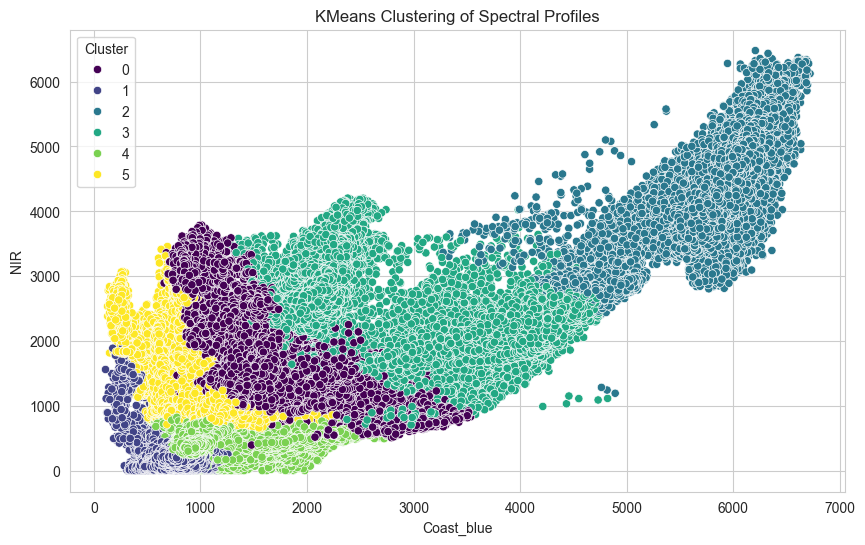

In [44]:
# Perform KMeans clustering
kmeans = KMeans(n_clusters=6, random_state=42)  # 6 clusters as 6 classes, can adjust 
clusters = kmeans.fit_predict(dataset[bands])

# Add clusters to the dataset
dataset['Cluster'] = clusters

# Plot the clusters
plt.figure(figsize=(10, 6))
sns.scatterplot(x='Coast_blue', y='NIR', hue='Cluster', data=dataset, palette='viridis')
plt.title('KMeans Clustering of Spectral Profiles')
plt.show()


In [45]:
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report

In [46]:
# Determine the number of unique classes
num_classes = dataset['labels'].nunique()
print(f"Number of unique classes: {num_classes}")

# Perform KMeans clustering with the number of clusters equal to the number of classes
kmeans = KMeans(n_clusters=num_classes, random_state=42)
clusters = kmeans.fit_predict(dataset[bands])

Number of unique classes: 6


In [47]:
# Add clusters to the dataset
dataset['Cluster'] = clusters

# Reduce dimensions for visualization using PCA
pca = PCA(n_components=2)
principal_components = pca.fit_transform(dataset[bands])
pca_df = pd.DataFrame(data=principal_components, columns=['PC1', 'PC2'])
pca_df['Cluster'] = clusters
pca_df['labels'] = dataset['labels']

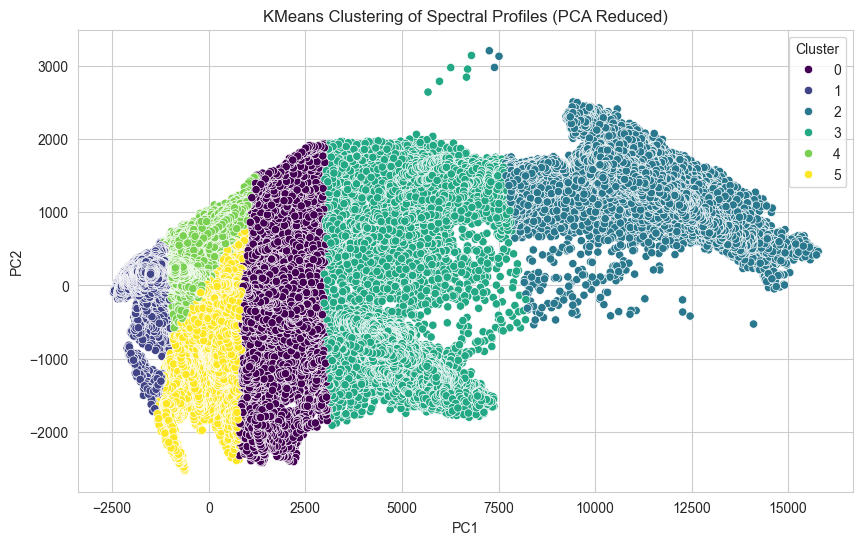

In [48]:
# Plot the clusters
plt.figure(figsize=(10, 6))
sns.scatterplot(x='PC1', y='PC2', hue='Cluster', data=pca_df, palette='viridis')
plt.title('KMeans Clustering of Spectral Profiles (PCA Reduced)')
plt.show()


In [49]:
# Compare clusters with actual labels
# Create a confusion matrix
conf_matrix = confusion_matrix(dataset['encoded_labels'], dataset['Cluster'])

# Print the confusion matrix
print("Confusion Matrix:")
print(conf_matrix)

Confusion Matrix:
[[  4884   2111     36   1495   3738  27987]
 [ 75925    318  36936  78076   3095 105881]
 [  6081 460268      5   1998 280854  30082]
 [ 10859  22850      0   3271  15396  40480]
 [   315      0      0      1      0    506]
 [    19      0      0      0      0     29]]


In [50]:
# Calculate the classification report
print("\nClassification Report:")
print(classification_report(dataset['encoded_labels'], dataset['Cluster'], target_names=le.classes_))


Classification Report:
              precision    recall  f1-score   support

  freshwater       0.05      0.12      0.07     40251
         ice       0.00      0.00      0.00    300231
       ocean       0.00      0.00      0.00    779288
        rock       0.04      0.04      0.04     92856
walrus_mixed       0.00      0.00      0.00       822
 walrus_pure       0.00      0.60      0.00        48

    accuracy                           0.01   1213496
   macro avg       0.01      0.13      0.02   1213496
weighted avg       0.00      0.01      0.01   1213496


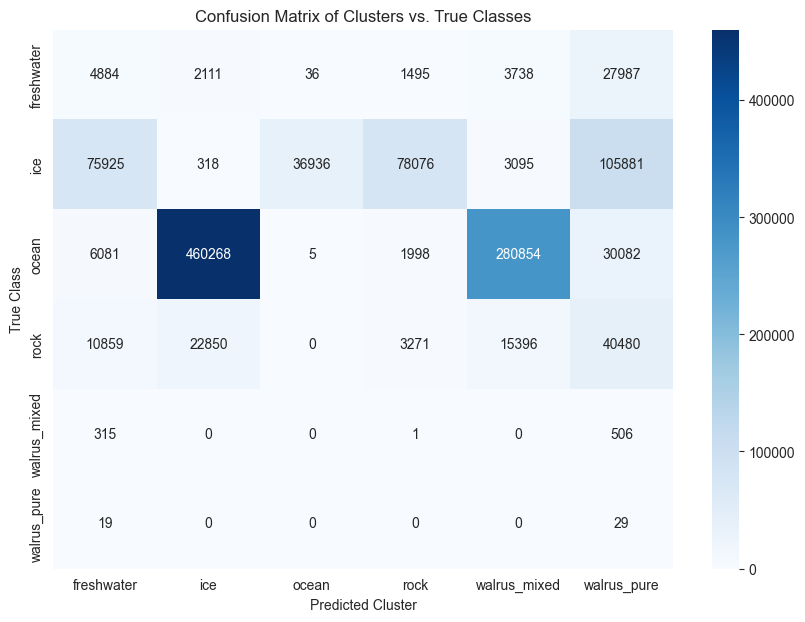

In [51]:
# Plot the confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=le.classes_, yticklabels=le.classes_)
plt.xlabel('Predicted Cluster')
plt.ylabel('True Class')
plt.title('Confusion Matrix of Clusters vs. True Classes')
plt.show()



Confusion Matrix for Coast_blue:
[[  3044      6  12959   1111    793  22338]
 [ 87272  35072  10424  77740   7460  82263]
 [ 88077      0 285369  37424   1013 367405]
 [ 51285      0   4612  10234      0  26725]
 [   390      0     25     37      0    370]
 [     0      0      0      0      0     48]]

Classification Report for Coast_blue:
              precision    recall  f1-score   support

  freshwater       0.01      0.08      0.02     40251
         ice       1.00      0.12      0.21    300231
       ocean       0.91      0.37      0.52    779288
        rock       0.08      0.11      0.09     92856
walrus_mixed       0.00      0.00      0.00       822
 walrus_pure       0.00      1.00      0.00        48

    accuracy                           0.28   1213496
   macro avg       0.33      0.28      0.14   1213496
weighted avg       0.84      0.28      0.40   1213496


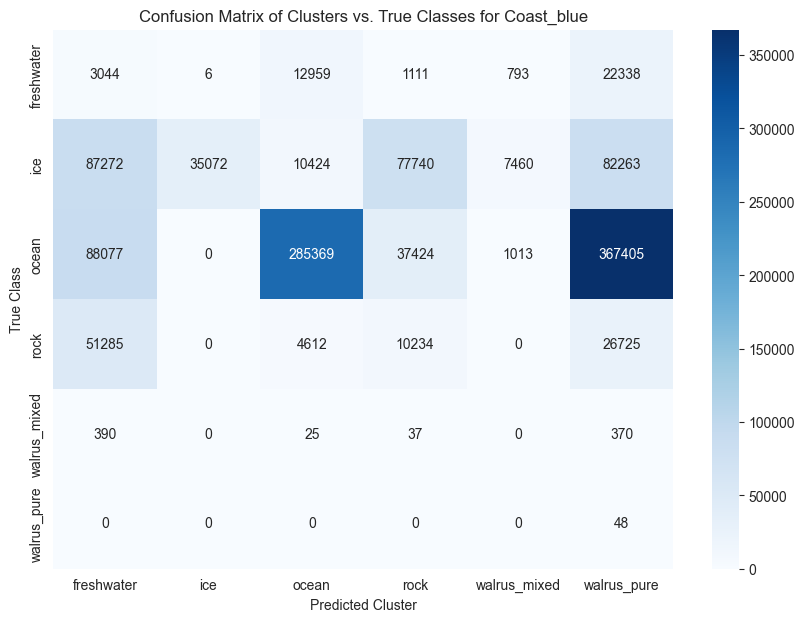


Confusion Matrix for Blue:
[[  4437      4  14698   1988  18933    191]
 [109447  34706  10287  78719  61287   5785]
 [118871      0 214991   2456 442856    114]
 [ 11733      0  28613   6185  46325      0]
 [   520      0      0     14    288      0]
 [    21      0      0      0     27      0]]

Classification Report for Blue:
              precision    recall  f1-score   support

  freshwater       0.02      0.11      0.03     40251
         ice       1.00      0.12      0.21    300231
       ocean       0.80      0.28      0.41    779288
        rock       0.07      0.07      0.07     92856
walrus_mixed       0.00      0.35      0.00       822
 walrus_pure       0.00      0.00      0.00        48

    accuracy                           0.21   1213496
   macro avg       0.31      0.15      0.12   1213496
weighted avg       0.77      0.21      0.32   1213496


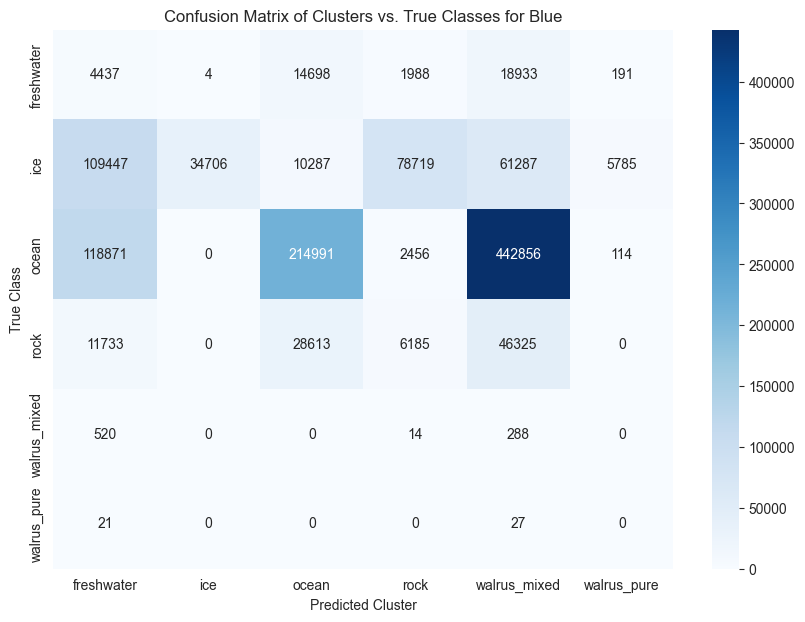


Confusion Matrix for Green1:
[[  3385     10  13942   1472  21015    427]
 [ 80820  34685   4454  76386  98152   5734]
 [ 75262      0 364275   3483 335835    433]
 [ 12673      0  24448   5502  50233      0]
 [   341      0      0      6    475      0]
 [     0      0      0      0     48      0]]

Classification Report for Green1:
              precision    recall  f1-score   support

  freshwater       0.02      0.08      0.03     40251
         ice       1.00      0.12      0.21    300231
       ocean       0.89      0.47      0.61    779288
        rock       0.06      0.06      0.06     92856
walrus_mixed       0.00      0.58      0.00       822
 walrus_pure       0.00      0.00      0.00        48

    accuracy                           0.34   1213496
   macro avg       0.33      0.22      0.15   1213496
weighted avg       0.83      0.34      0.45   1213496


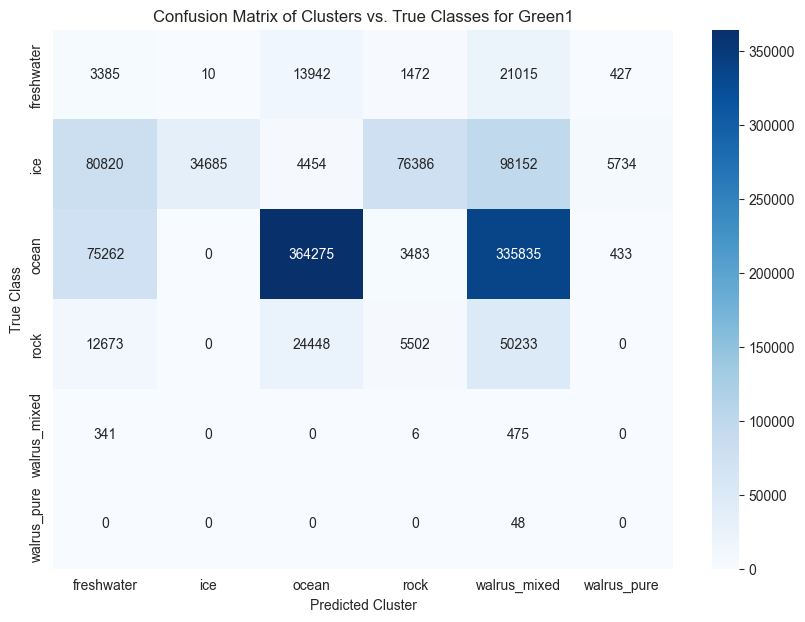


Confusion Matrix for Green:
[[  3033   6777     31    876  16561  12973]
 [ 35731    634  36631  74628  38093 114514]
 [  2588 323503      0   1214 341415 110568]
 [ 10018  31074      0   1105  44250   6409]
 [    78      0      0      0    172    572]
 [     0      0      0      0     24     24]]

Classification Report for Green:
              precision    recall  f1-score   support

  freshwater       0.06      0.08      0.07     40251
         ice       0.00      0.00      0.00    300231
       ocean       0.00      0.00      0.00    779288
        rock       0.01      0.01      0.01     92856
walrus_mixed       0.00      0.21      0.00       822
 walrus_pure       0.00      0.50      0.00        48

    accuracy                           0.00   1213496
   macro avg       0.01      0.13      0.01   1213496
weighted avg       0.00      0.00      0.00   1213496


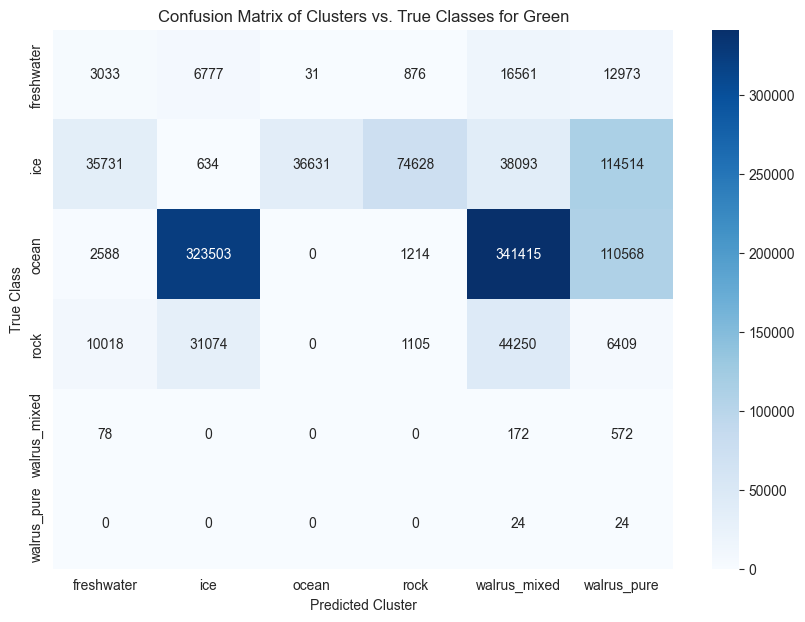


Confusion Matrix for Yellow:
[[  2907    722  17227     44   1522  17829]
 [ 63606      4  23527  36295  76228 100571]
 [ 18047 403216 248646      6   2357 107016]
 [ 11598  11940  42085      0   1674  25559]
 [   203      0     47      0      0    572]
 [     0      0     24      0      0     24]]

Classification Report for Yellow:
              precision    recall  f1-score   support

  freshwater       0.03      0.07      0.04     40251
         ice       0.00      0.00      0.00    300231
       ocean       0.75      0.32      0.45    779288
        rock       0.00      0.00      0.00     92856
walrus_mixed       0.00      0.00      0.00       822
 walrus_pure       0.00      0.50      0.00        48

    accuracy                           0.21   1213496
   macro avg       0.13      0.15      0.08   1213496
weighted avg       0.48      0.21      0.29   1213496


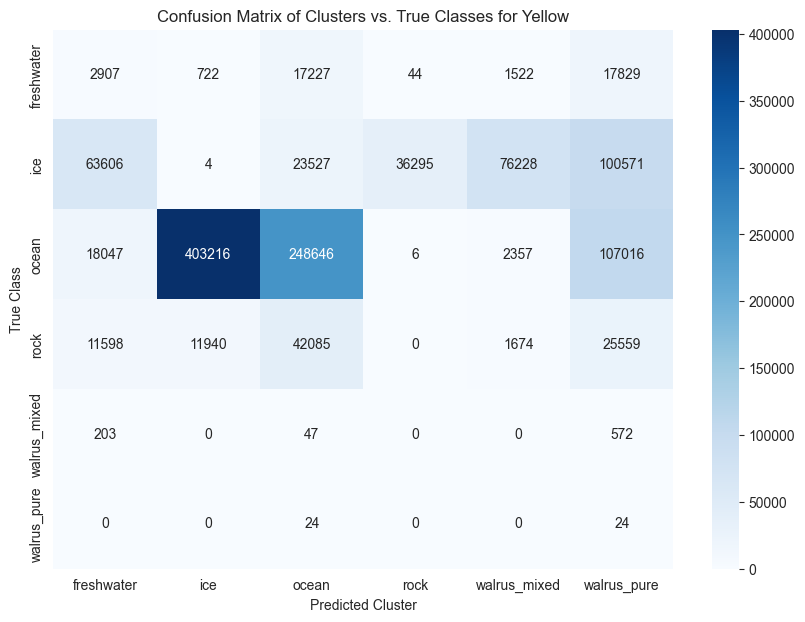


Confusion Matrix for Red:
[[  3515    622  16931     29    724  18430]
 [ 57238    694  22394  35509  75671 108725]
 [  5786 501400 204521      6    987  66588]
 [  9762  25843  46145      0   1575   9531]
 [   164      0      2      0      4    652]
 [     0      0      0      0      0     48]]

Classification Report for Red:
              precision    recall  f1-score   support

  freshwater       0.05      0.09      0.06     40251
         ice       0.00      0.00      0.00    300231
       ocean       0.71      0.26      0.38    779288
        rock       0.00      0.00      0.00     92856
walrus_mixed       0.00      0.00      0.00       822
 walrus_pure       0.00      1.00      0.00        48

    accuracy                           0.17   1213496
   macro avg       0.13      0.23      0.07   1213496
weighted avg       0.45      0.17      0.25   1213496


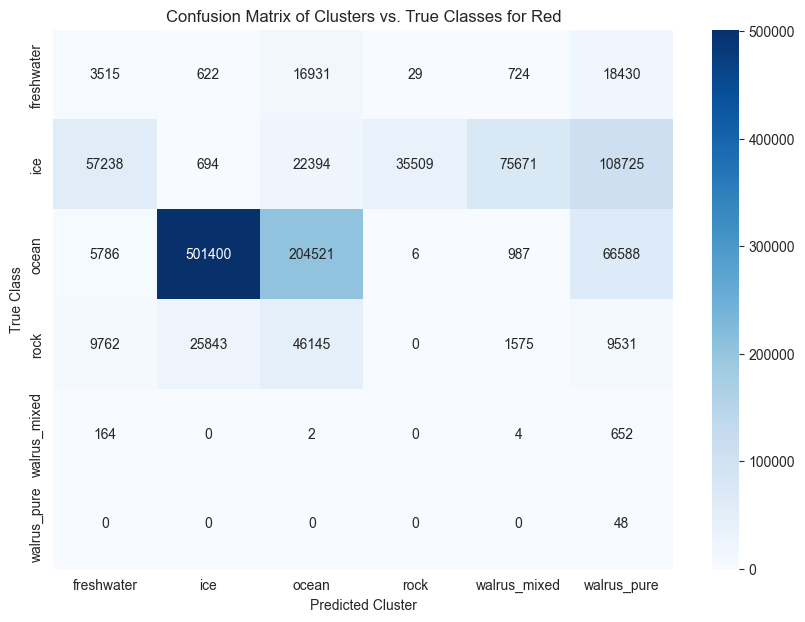


Confusion Matrix for Red_edge:
[[  5589     43  20713     38   1208  12660]
 [ 66074    671 103804  34823  74969  19890]
 [  5028 602265  44605      6    907 126477]
 [ 10408  22153  33337      0   1699  25259]
 [   241      0    581      0      0      0]
 [    19      0     29      0      0      0]]

Classification Report for Red_edge:
              precision    recall  f1-score   support

  freshwater       0.06      0.14      0.09     40251
         ice       0.00      0.00      0.00    300231
       ocean       0.22      0.06      0.09    779288
        rock       0.00      0.00      0.00     92856
walrus_mixed       0.00      0.00      0.00       822
 walrus_pure       0.00      0.00      0.00        48

    accuracy                           0.04   1213496
   macro avg       0.05      0.03      0.03   1213496
weighted avg       0.14      0.04      0.06   1213496


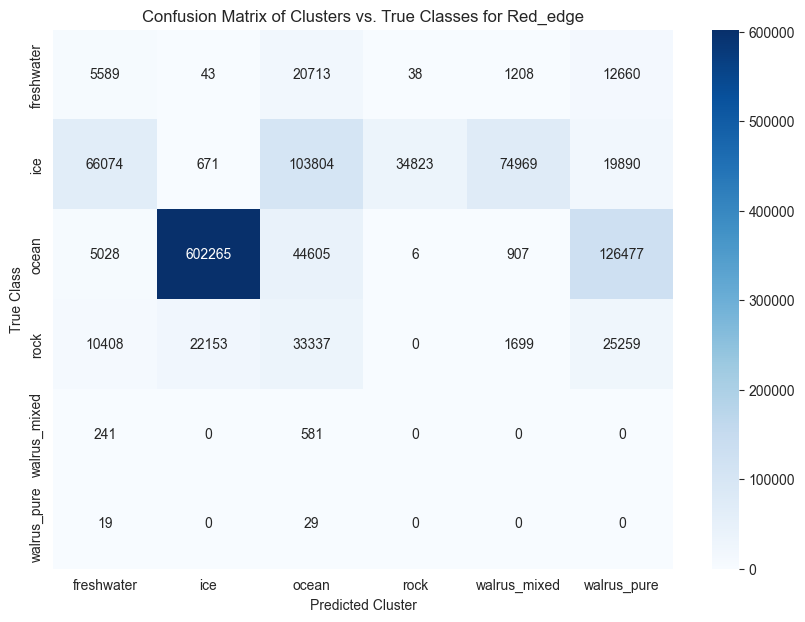


Confusion Matrix for NIR:
[[  6072    182  19056     48   3924  10969]
 [ 67741   1548 101380  30064  68136  31362]
 [  1412 739297   8035      5    159  30380]
 [ 26947  26929  16884      0   2459  19637]
 [   284      0    492      0      3     43]
 [    37      0     11      0      0      0]]

Classification Report for NIR:
              precision    recall  f1-score   support

  freshwater       0.06      0.15      0.09     40251
         ice       0.00      0.01      0.00    300231
       ocean       0.06      0.01      0.02    779288
        rock       0.00      0.00      0.00     92856
walrus_mixed       0.00      0.00      0.00       822
 walrus_pure       0.00      0.00      0.00        48

    accuracy                           0.01   1213496
   macro avg       0.02      0.03      0.02   1213496
weighted avg       0.04      0.01      0.01   1213496


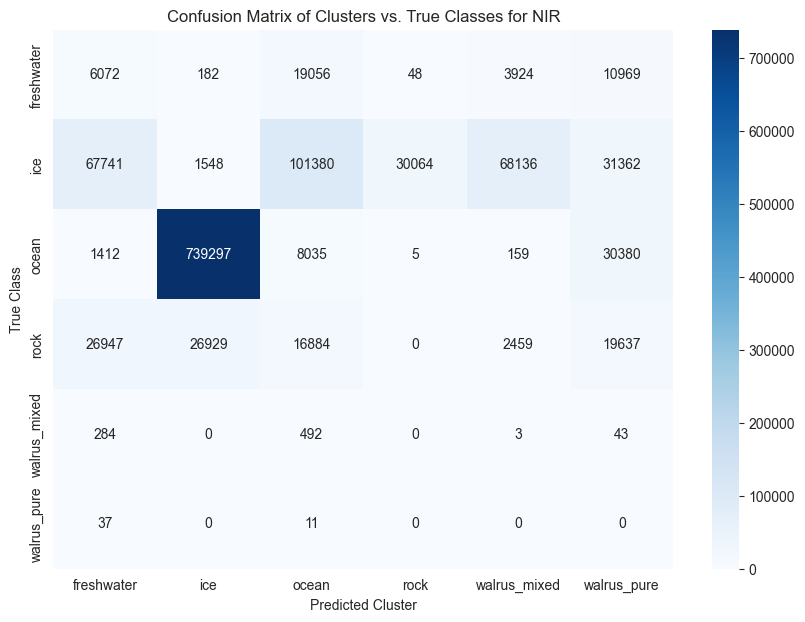

In [52]:
# Perform KMeans clustering on each band separately and compare to actual labels
for band in bands:
    kmeans = KMeans(n_clusters=num_classes, random_state=42)
    clusters = kmeans.fit_predict(dataset[[band]])

    # Add clusters to the dataset
    dataset[f'Cluster_{band}'] = clusters

    # Compare clusters with actual labels
    conf_matrix = confusion_matrix(dataset['encoded_labels'], dataset[f'Cluster_{band}'])

    # Print the confusion matrix
    print(f"\nConfusion Matrix for {band}:")
    print(conf_matrix)

    # Calculate the classification report
    print(f"\nClassification Report for {band}:")
    print(classification_report(dataset['encoded_labels'], dataset[f'Cluster_{band}'], target_names=le.classes_))

    # Plot the confusion matrix
    plt.figure(figsize=(10, 7))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=le.classes_, yticklabels=le.classes_)
    plt.xlabel('Predicted Cluster')
    plt.ylabel('True Class')
    plt.title(f'Confusion Matrix of Clusters vs. True Classes for {band}')
    plt.show()


Random Forest or SVM can classify the spectral profiles by considering the entire profile as a single input.

In [55]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import pandas as pd

In [56]:
# Prepare the data
X = dataset[bands].values
y = dataset['encoded_labels'].values

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train a Random Forest model
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

# Predict and evaluate
y_pred = rf_model.predict(X_test)
print(classification_report(y_test, y_pred, target_names=le.classes_))

# Feature importances
importances = rf_model.feature_importances_
feature_importances = pd.DataFrame({'feature': bands, 'importance': importances}).sort_values(by='importance', ascending=False)
print(feature_importances)


              precision    recall  f1-score   support

  freshwater       0.91      0.88      0.90      8044
         ice       0.98      0.99      0.98     60098
       ocean       1.00      1.00      1.00    155893
        rock       0.98      0.97      0.97     18474
walrus_mixed       1.00      0.28      0.44       178
 walrus_pure       0.86      0.92      0.89        13

    accuracy                           0.99    242700
   macro avg       0.95      0.84      0.86    242700
weighted avg       0.99      0.99      0.99    242700

      feature  importance
7         NIR    0.279087
5         Red    0.170003
6    Red_edge    0.137778
1        Blue    0.098546
3       Green    0.096736
0  Coast_blue    0.084348
4      Yellow    0.080210
2      Green1    0.053293


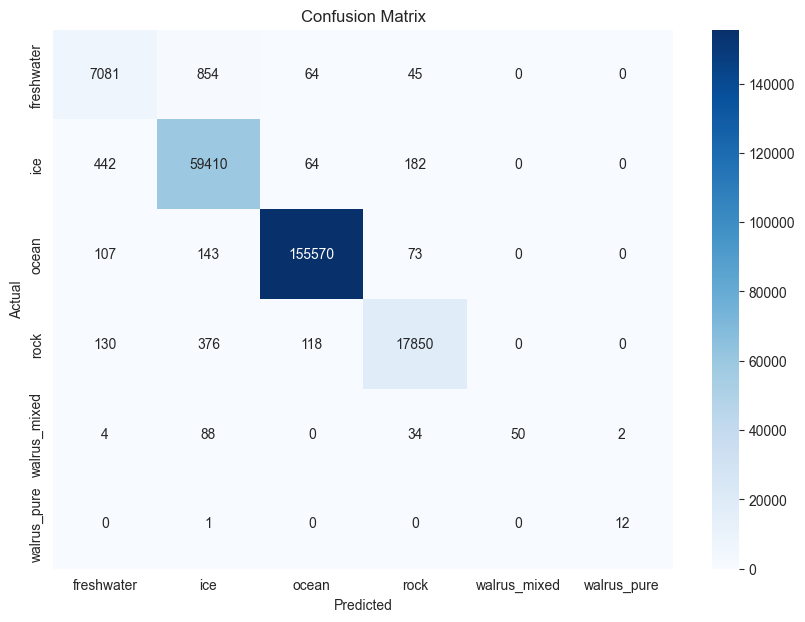

In [59]:
# Confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)

# Plot confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=le.classes_, yticklabels=le.classes_)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

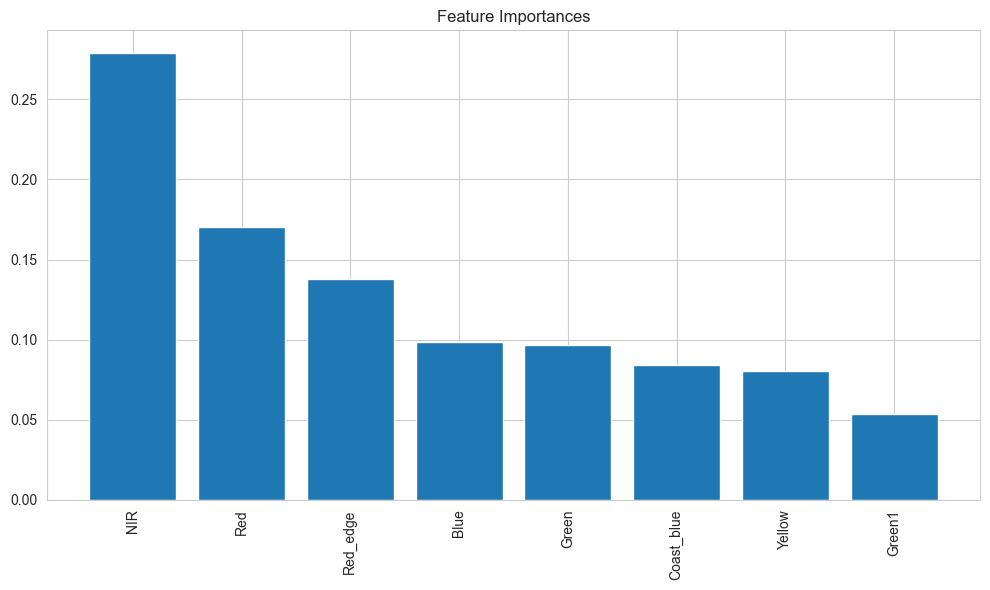

In [60]:
# Feature importance
importances = model.feature_importances_
indices = np.argsort(importances)[::-1]

# Plot feature importances
plt.figure(figsize=(10, 6))
plt.title('Feature Importances')
plt.bar(range(X.shape[1]), importances[indices], align='center')
plt.xticks(range(X.shape[1]), [bands[i] for i in indices], rotation=90)
plt.tight_layout()
plt.show()

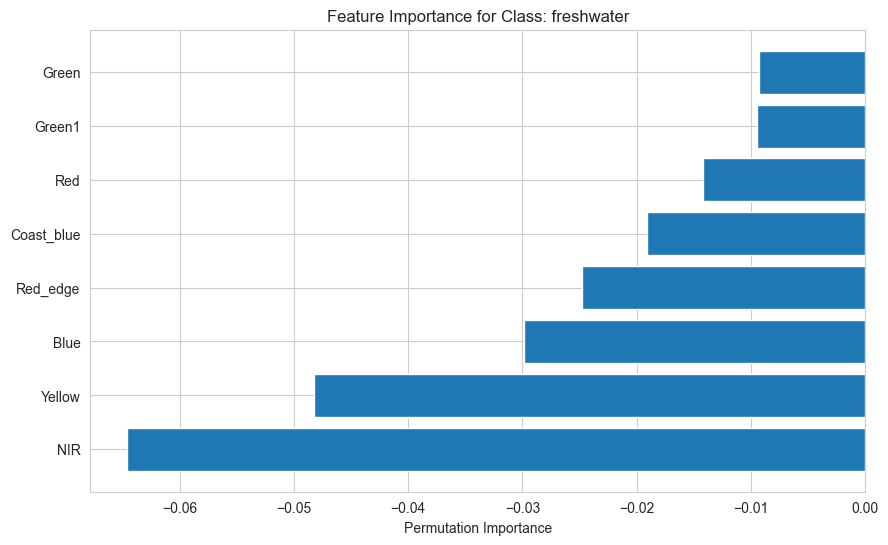

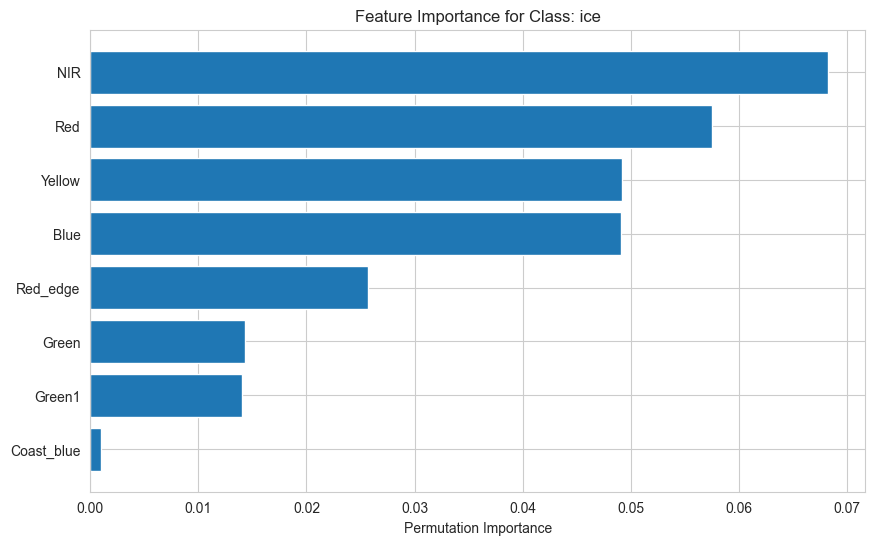

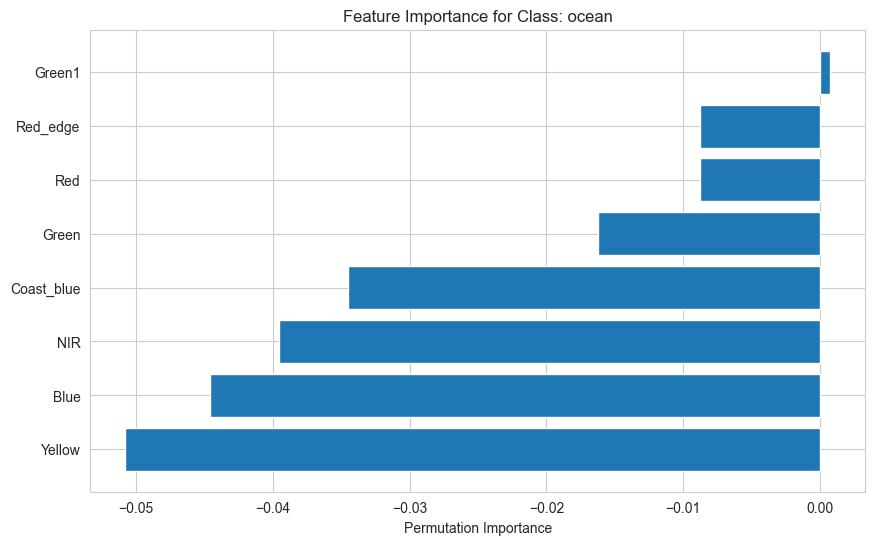

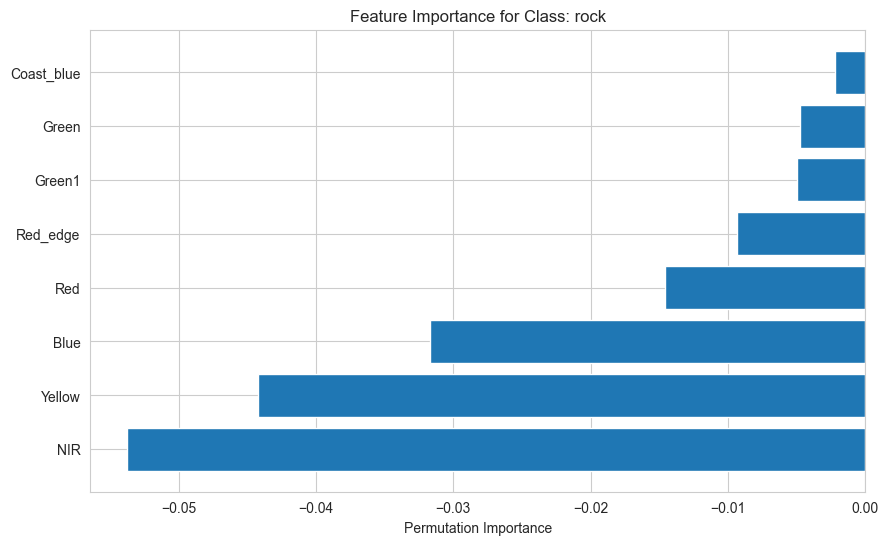

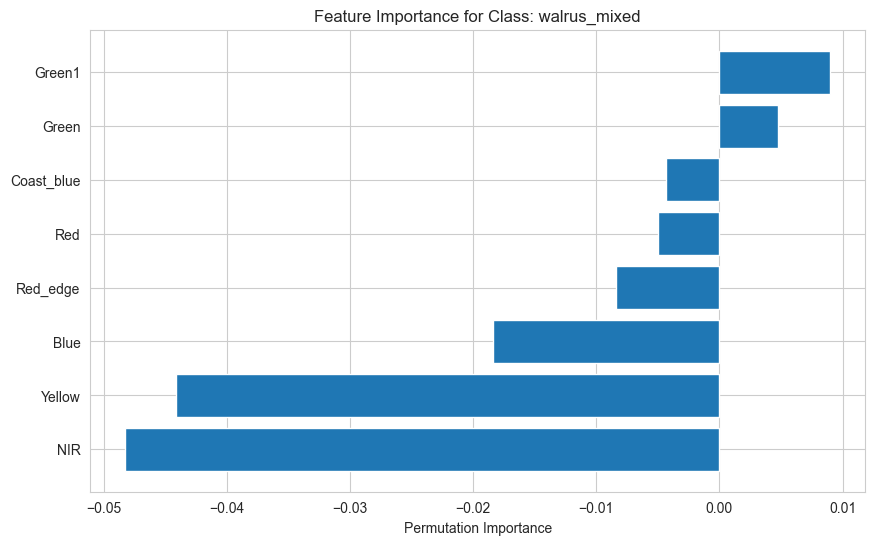

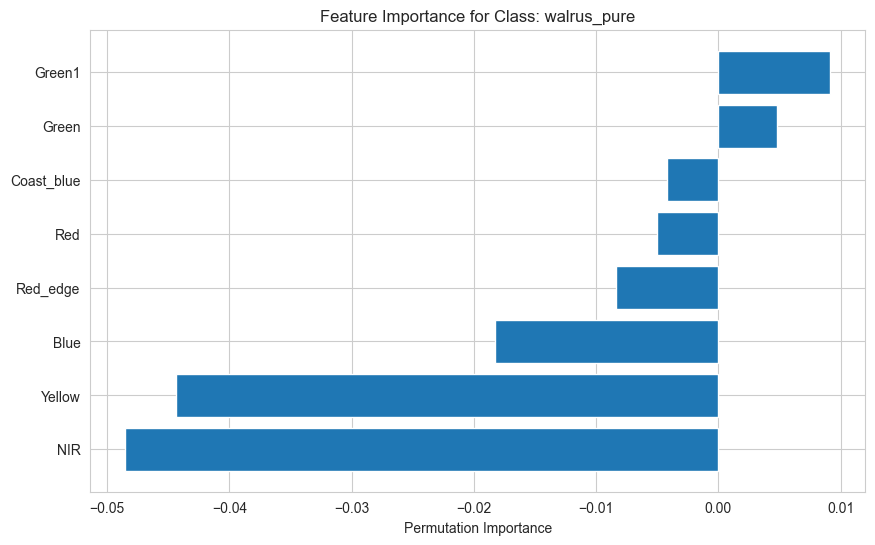

In [66]:
# Permutation feature importance for each class
for i, class_name in enumerate(le.classes_):
    class_importance = permutation_importance(model, X_test, y_test == i, n_repeats=10, random_state=42, n_jobs=2)
    sorted_idx = class_importance.importances_mean.argsort()
    plt.figure(figsize=(10, 6))
    plt.barh(np.array(bands)[sorted_idx], class_importance.importances_mean[sorted_idx])
    plt.xlabel("Permutation Importance")
    plt.title(f"Feature Importance for Class: {class_name}")
    plt.show()

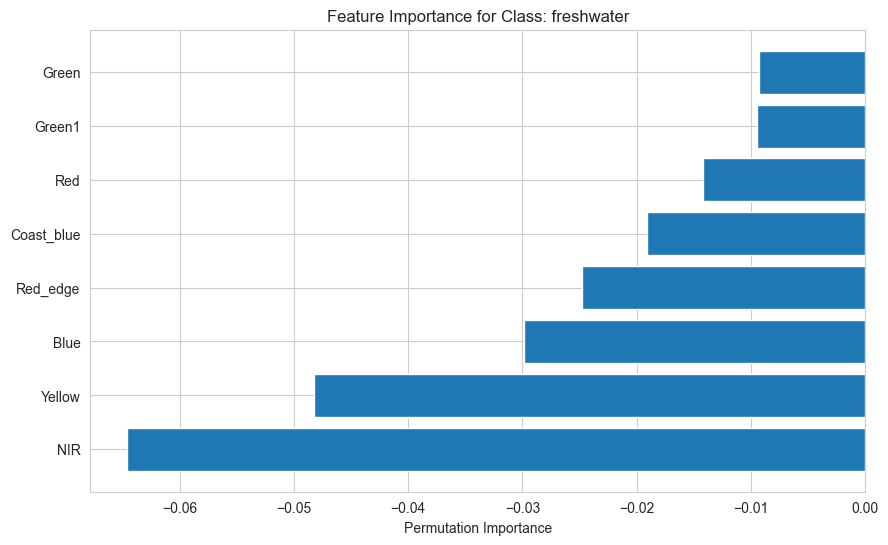


Permutation Importance for Class: freshwater
NIR: -0.0646
Yellow: -0.0482
Blue: -0.0299
Red_edge: -0.0248
Coast_blue: -0.0191
Red: -0.0142
Green1: -0.0095
Green: -0.0093


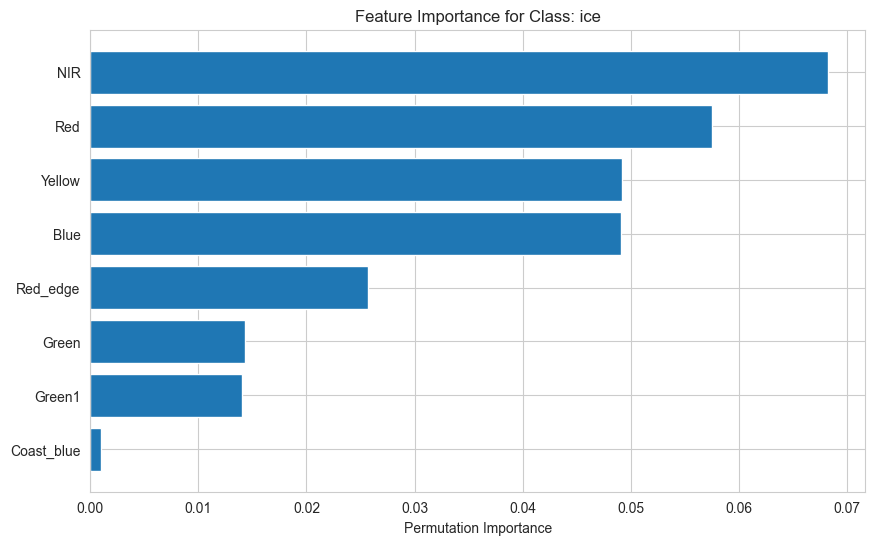


Permutation Importance for Class: ice
Coast_blue: 0.0010
Green1: 0.0141
Green: 0.0143
Red_edge: 0.0257
Blue: 0.0491
Yellow: 0.0492
Red: 0.0575
NIR: 0.0683


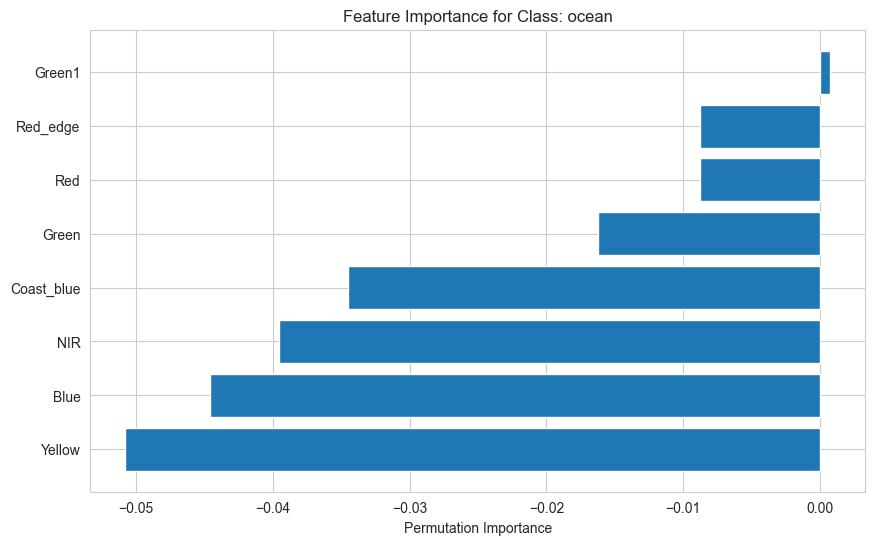


Permutation Importance for Class: ocean
Yellow: -0.0508
Blue: -0.0446
NIR: -0.0396
Coast_blue: -0.0345
Green: -0.0162
Red: -0.0088
Red_edge: -0.0088
Green1: 0.0007


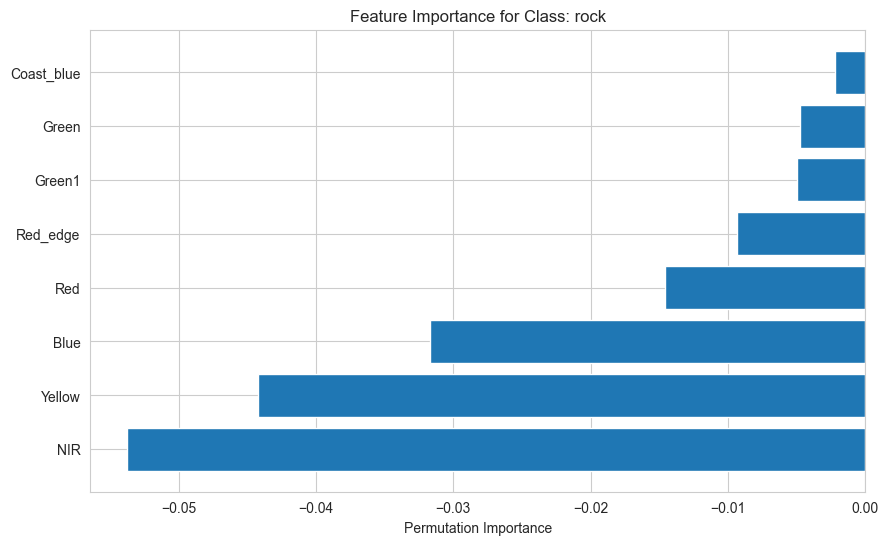


Permutation Importance for Class: rock
NIR: -0.0537
Yellow: -0.0442
Blue: -0.0317
Red: -0.0146
Red_edge: -0.0094
Green1: -0.0049
Green: -0.0047
Coast_blue: -0.0022


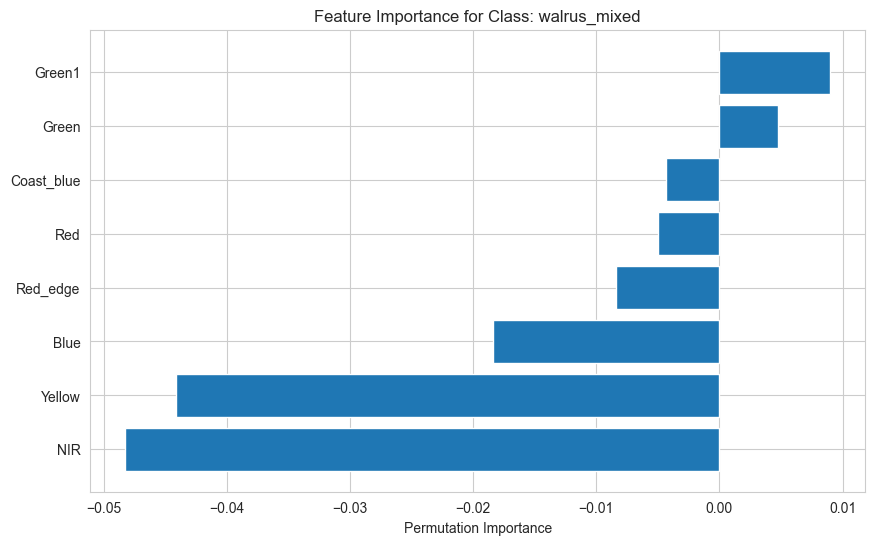


Permutation Importance for Class: walrus_mixed
NIR: -0.0482
Yellow: -0.0442
Blue: -0.0184
Red_edge: -0.0084
Red: -0.0050
Coast_blue: -0.0043
Green: 0.0047
Green1: 0.0090


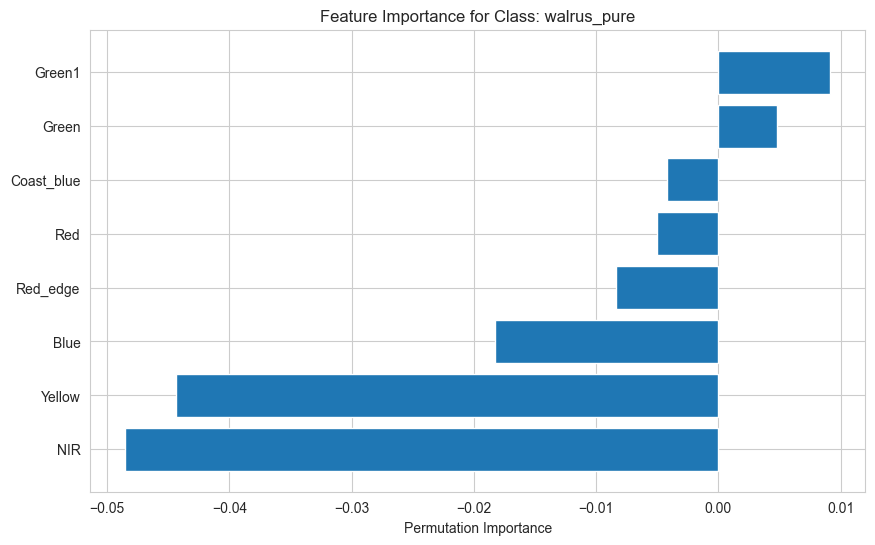


Permutation Importance for Class: walrus_pure
NIR: -0.0485
Yellow: -0.0443
Blue: -0.0183
Red_edge: -0.0084
Red: -0.0050
Coast_blue: -0.0042
Green: 0.0048
Green1: 0.0091


In [67]:
from sklearn.inspection import permutation_importance

# Permutation feature importance for each class
for i, class_name in enumerate(le.classes_):
    class_specific = (y_test == i).astype(int)  # Create a binary mask for the class
    class_importance = permutation_importance(model, X_test, class_specific, n_repeats=10, random_state=42, n_jobs=2)
    sorted_idx = class_importance.importances_mean.argsort()
    
    plt.figure(figsize=(10, 6))
    plt.barh(np.array(bands)[sorted_idx], class_importance.importances_mean[sorted_idx])
    plt.xlabel("Permutation Importance")
    plt.title(f"Feature Importance for Class: {class_name}")
    plt.show()

    # Print the permutation importance values
    print(f"\nPermutation Importance for Class: {class_name}")
    for idx in sorted_idx:
        print(f"{bands[idx]}: {class_importance.importances_mean[idx]:.4f}")


In [57]:
from scipy.stats import ttest_ind

In [58]:
# Get predicted probabilities
y_proba = rf_model.predict_proba(X_test)

# Prepare a DataFrame with predicted probabilities and true labels
proba_df = pd.DataFrame(y_proba, columns=le.classes_)
proba_df['true_label'] = le.inverse_transform(y_test)

# Perform pairwise comparisons using t-test on predicted probabilities
results = []
for class1 in le.classes_:
    for class2 in le.classes_:
        if class1 != class2:
            group1 = proba_df[proba_df['true_label'] == class1][class1]
            group2 = proba_df[proba_df['true_label'] == class2][class1]
            tval, pval = ttest_ind(group1, group2, equal_var=False)
            results.append((class1, class2, tval, pval))

# Convert results to DataFrame for easier viewing
results_df = pd.DataFrame(results, columns=['Class 1', 'Class 2', 't-value', 'p-value'])
print(results_df)


         Class 1       Class 2      t-value        p-value
0     freshwater           ice   289.347054   0.000000e+00
1     freshwater         ocean   298.104129   0.000000e+00
2     freshwater          rock   289.684367   0.000000e+00
3     freshwater  walrus_mixed    82.373203  4.298246e-165
4     freshwater   walrus_pure    55.336626   6.953469e-17
5            ice    freshwater   318.712482   0.000000e+00
6            ice         ocean  2313.674498   0.000000e+00
7            ice          rock   993.413781   0.000000e+00
8            ice  walrus_mixed    21.780166   5.682022e-52
9            ice   walrus_pure    23.329229   2.285631e-11
10         ocean    freshwater  1203.233658   0.000000e+00
11         ocean           ice  5898.087741   0.000000e+00
12         ocean          rock  1997.198576   0.000000e+00
13         ocean  walrus_mixed   438.308633  9.863828e-272
14         ocean   walrus_pure  1280.413416   2.397075e-33
15          rock    freshwater   654.470571   0.000000e+

SHAP values (SHapley Additive exPlanations) are a way of breaking down a prediction to show the impact of each feature

In [ ]:
import shap

# Prepare the data for SHAP
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_test)

# Plot SHAP summary plot for each class
for i, class_name in enumerate(le.classes_):
    plt.title(f"SHAP Summary for Class: {class_name}")
    shap.summary_plot(shap_values[i], X_test, feature_names=bands)
